# 0.0 Imports

In [66]:
import inflection
import math
import time
import random
import pickle
import warnings

import seaborn  as sns
import numpy    as np
import pandas   as pd
import xgboost  as xgb

from IPython.display       import Image
from IPython.core.display  import HTML
from datetime              import datetime,timedelta
from tabulate              import tabulate
from scipy                 import stats
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression,Lasso
from flask                 import Flask,request,Response

from matplotlib            import pyplot as plt

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [23]:
def jupyter_settings():
    """Definições padrões setadas para o uso o Jupyter Notebook."""
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [67]:
#Executando a função
jupyter_settings();

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [26]:
#Definindo a função de cramer V
def cramer_v(x,y):
    """Função para executar o cálculo Cramer's V."""
    #Combinações entre as variáveis categóricas, e conta as contagens
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

In [39]:
def mean_percentage_error(y_real,y_estimado):
    """Definindo a função do MPE.
    
    y_real - dados reais do fenômeno
    y_estimado - dados estimados pelo modelo - yhat
    """
    return np.mean((y_real - y_estimado)/y_real)

def mean_absolute_percentage_error(y_real,y_estimado):
    """Função para calcular o MAE, MAPE e RMSE de cada modelo aplicado.
    
    y_real - dados reais do fenômeno
    y_estimado - dados estimados pelo modelo - yhat
    """
    return np.mean(np.abs((y_real - y_estimado)/y_real))

def ml_error(model_name,y_real,y_estimado):
    """Função para calcular o MAE, MAPE e RMSE de cada modelo aplicado.
    
    model_name - String do nome do modelo
    y_real - dados reais do fenômeno
    y_estimado - dados estimados pelo modelo - yhat
    """
    mae = mean_absolute_error(y_real,y_estimado)
    mape = mean_absolute_percentage_error(y_real,y_estimado)
    rmse = np.sqrt(mean_squared_error(y_real,y_estimado))
        
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                             'MAPE':mape,
                             'RMSE':rmse},index=[0])

In [40]:
def cross_validation(x_training,kfold,model_name,model,verbose=False):
    """Função para treinar o modelo em diferentes espaços das amotra e retornar o valor dos eus erros, juntamente com seus ranges.
    
    x_training - Dataset de Treino
    kfold - Número de intervalos em que o modelo será treinado
    model_name - String do nome do modelo
    model - Modelo já instanciado
    verbose - Vizualização do progresso do Cross Validation
    """
    #Selecionar o primeiro espaço de validação, 6 semanas até o fim do treino - start and end for date validation
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print(f'K = {k}')
        validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - timedelta(days=(k-1)*6*7)

        #Filtrar o dataset
        training = x_training[x_training['date'] < validation_start_date] #Resto dos dados
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)] #Começo até o início do treino

        training_start = training['date'].max()
        training_end = training['date'].min()

        validation_start = validation['date'].max()
        validation_end = validation['date'].min()

        #Training and validation dataset
        #training
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        #Como fizemos para selecionar as variáveis para o Boruta
        #Estamos selecionando os datasets de treino e validação

        #model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance - Y_test é a coluna de sales que devemos encontrar e yhat é o que nosso método prediz
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        #Guardando a performance de cada iteração
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,
         'MAE CV':np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
         'MAPE CV':np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
         'RSME CV':np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

## 0.1 Loading Data

In [41]:
#Lendo os datasets do sales e store
df_sales_raw = pd.read_csv('dataset/train.csv',low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv',low_memory=False)

#Fazendo o merge dos datasets e printando para ter uma noção das colunas
df_raw = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')
df_raw.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [42]:
#Cópia de segurança 1
df1 = df_raw.copy()

## 1.1 Rename Columns

In [43]:
#Colocando como snake case
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snake_case = lambda x: inflection.underscore(x)
cols_new = list(map(snake_case,cols_old))

##Rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [45]:
#Noção da dimensão do dataset
print(f'Número de linhas - {df1.shape[0]}')
print(f'Número de colunas - {df1.shape[1]}')

Número de linhas - 1017209
Número de colunas - 18


## 1.3 Data Types

In [46]:
#Mudar o tipo do date de object para data e observar a mudança
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Chack NA

In [47]:
#Número de NAs por colunas
print(df1.isna().sum())

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64


## 1.5 Fillout NA

In [48]:
#competition_distance              2642
#Vamos completar essa coluna com um valor muito mais alto que o maior valor da caluna, pois para ela ser NA
#Essa loja não tem um competidor próximo, então colocamos um alto valor para representar isso
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)


#competition_open_since_month    323348
#Nesse caso, vamos utilizar a data que temos como parâmetro para essa data
#Derivamos o mes de date para o início da data de competição
#O mesmo fazemos para competition_open_since_year,promo2_since_week e promo2_since_year
df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)


#competition_open_since_year     323348
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)


#promo2_since_week               508031
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval                  508031
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
#Prenchendo os NA com 0
df1['promo_interval'].fillna(0,inplace=True)
#Criando a coluna month_map que será igual ao mês da data, mas com o nome do Mês, não o número
df1['month_map'] = df1['date'].dt.month.map(month_map)
#Criando a coluna is_promo que é basicamente 1 se o mês do month_map estiver no promo_interval
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

## 1.6 Change Types

In [49]:
#Depois de alterar os dados das colunas é bom conferir os tipos de ajustá-los
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [50]:
#Separando os tipos de tipos das colunas entre numéricas e categóricas
num_atrr = df1.select_dtypes(include=['int64','float64'])
cat_atrr = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1  Numerical Attributes

In [51]:
# Ter uma noção geral das métricas do negócio
# Central Tendency = mean, median
ct1 = pd.DataFrame(num_atrr.apply(np.mean)).T
ct2 = pd.DataFrame(num_atrr.apply(np.median)).T

# Dispersion = std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atrr.apply(np.std)).T
d2 = pd.DataFrame(num_atrr.apply(np.min)).T
d3 = pd.DataFrame(num_atrr.apply(np.max)).T
d4 = pd.DataFrame(num_atrr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_atrr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_atrr.apply(lambda x: x.kurtosis())).T

#Concaterando as métricas
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kustosis']
m

,attributes,min,max,range,mean,median,std,skew,kustosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


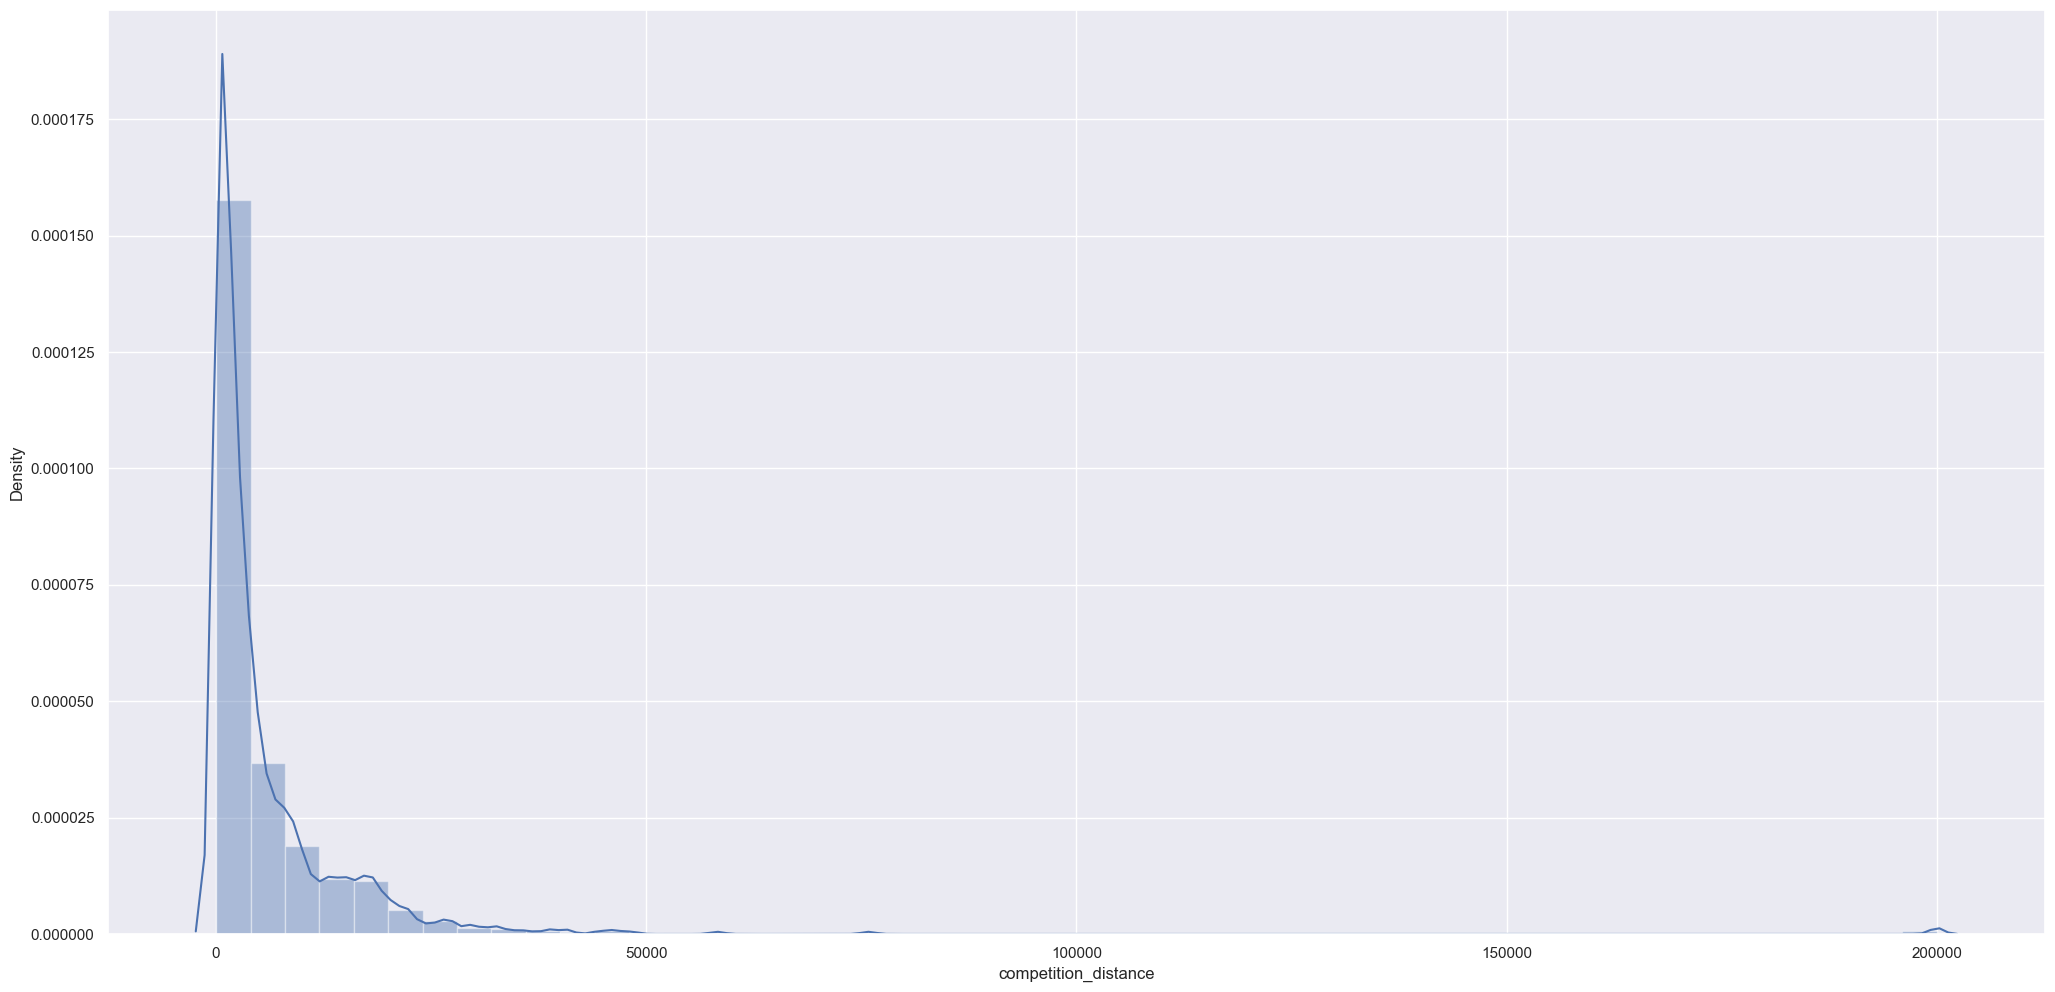

In [68]:
#Gráfico da competition_distance - Pedemos ver que a maioria das lojas tem um competidor próximo
#Além disso, a quantidade de NA que substituimos por um valor alto é bem pequena, considerando esses parâmetros
sns.distplot(df1['competition_distance']);

### 1.7.2 Categorical Attributes

In [53]:
#Valores únicos de cada categoria
cat_atrr.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

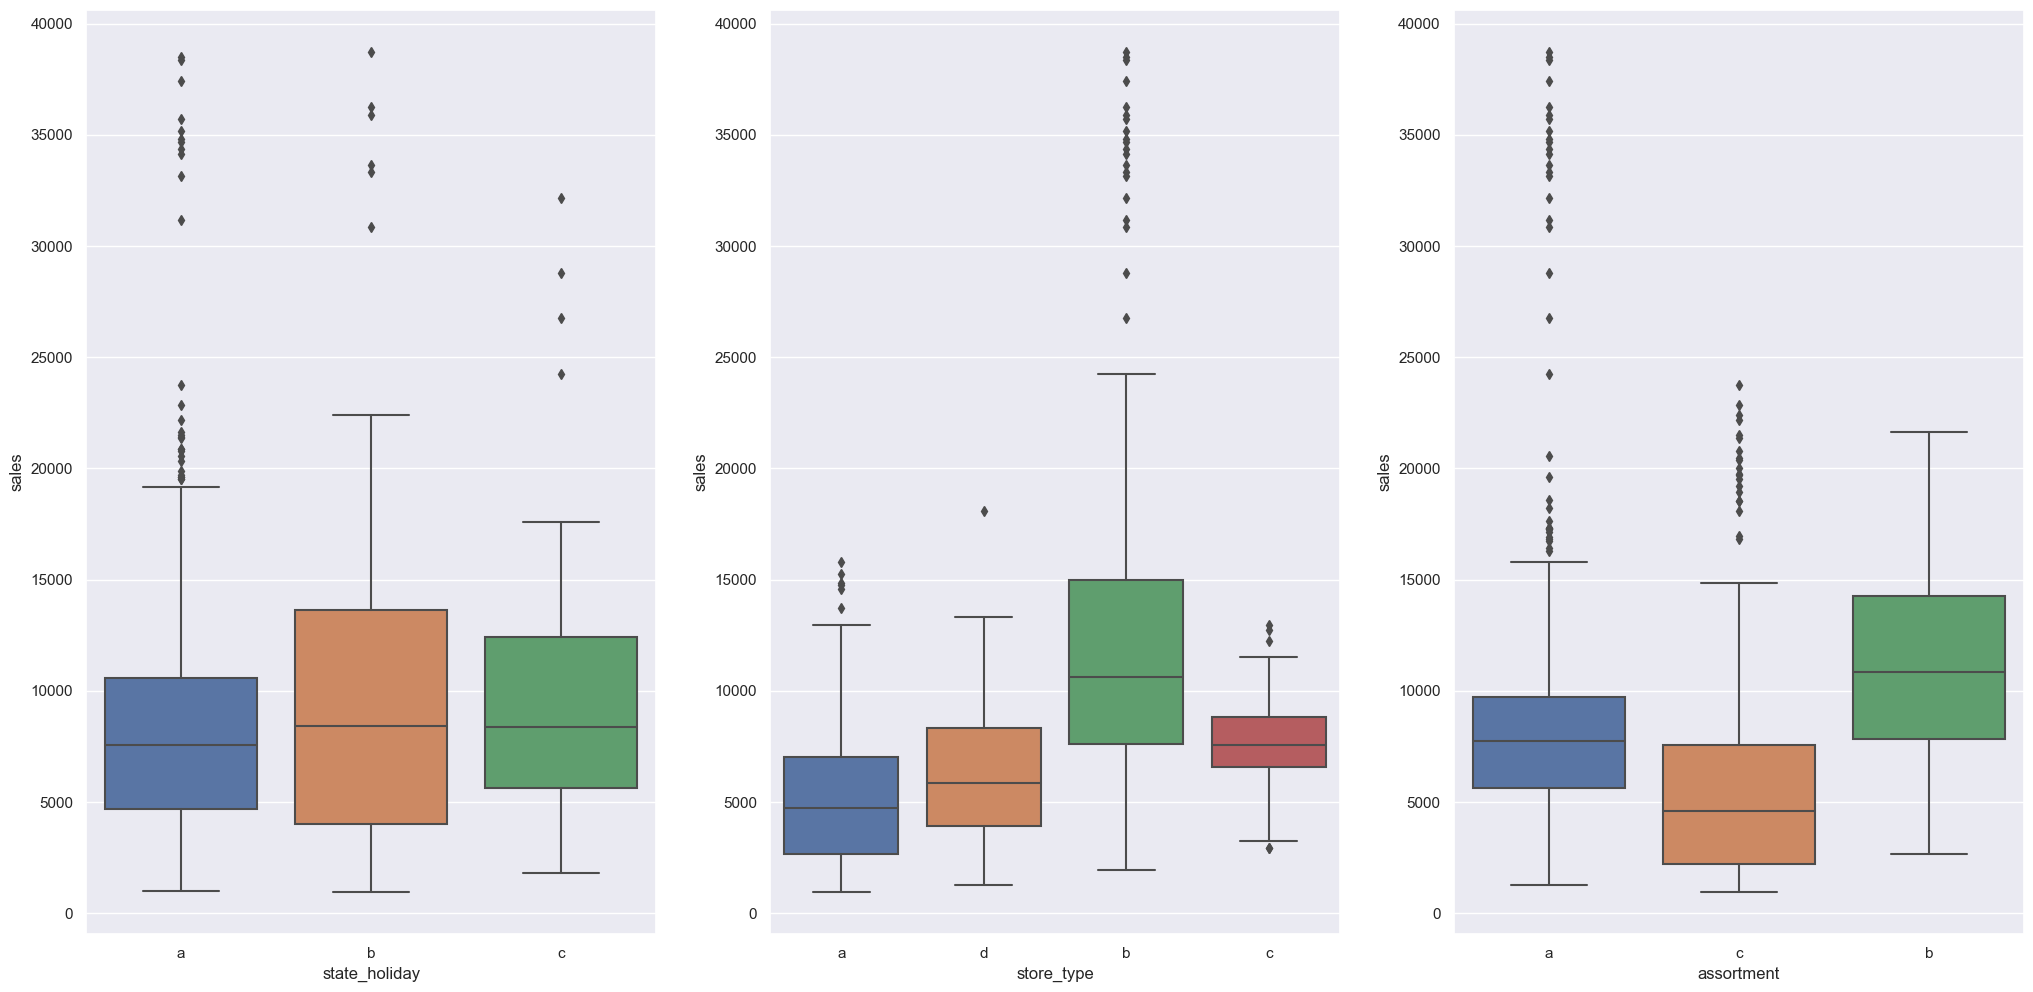

In [55]:
#Como estão as minhas variáveis categóricas em relação as vendas?

#Tirando os dias que teve  feriado, a loja fechou e não vendeu
#Assim, fica apenas dias que tem feriado e teve vendas
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Engenerring

In [56]:
#Cópia de segurança 2
df2 = df1.copy()

## 2.1 Mapa mental de Hipóteses

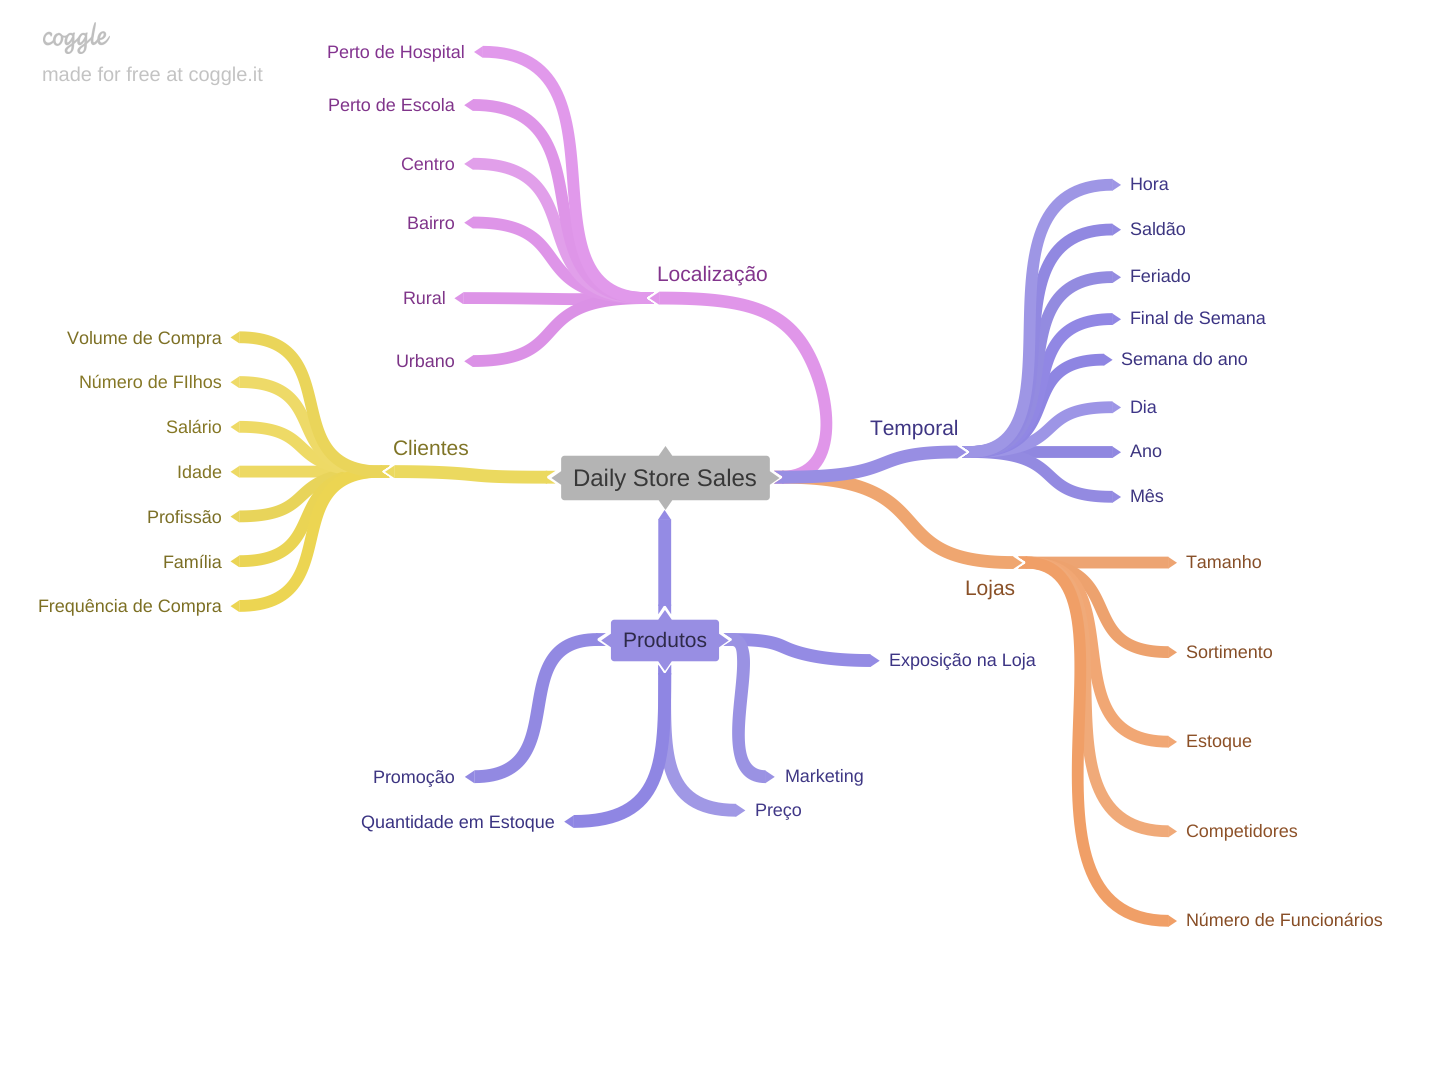

In [57]:
Image('img/mindmap_hipoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipóteses

#### Você tem ou não o dado disponível e preparado para esse momento?

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engeneering

In [58]:
#Esse snippet sempre da erro ao rodar a primeira vez, importando as libs de tempo, ele cancela o erro
import time
from datetime import datetime,timedelta

#Variáveis para devivar de date
#year, month, day, week of year, year week
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['week_of_year'] = df2['date'].dt.strftime("%U")
df2['year-week'] = df2['date'].dt.strftime('%Y-%W')

#Transformando as variáveis em int
df4['year'] = df4['year'].astype('int64')
df4['month'] = df4['month'].astype('int64')
df4['day'] = df4['day'].astype('int64')
df4['week_of_year'] = df4['week_of_year'].astype('int64')


#Variáveis de competição
#competition since, promo since
#Juntar o ano da competição com o mês para mostrar o tempo da competição ativa por mês
df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

#Tempo que minha competição está ativa em semanas
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1' , '%Y-%W-%w') - timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


#Variáveis que estão com letras e quero trocar por nomes
#assostment,state holiday
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Filtragem de variáveis

In [59]:
#Cópia de segurança 3
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [60]:
#open não tem aprendizado, pois quando está fechado não influencia na quantidade de vendas, precisa ser diferente de 0
#sales precisa ser maior que zero, para não considerar os dias fechados
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [61]:
#custumers não tem como usar no momento da predição, pois não tem como saber quantos clientes vão ter na loja para influenciar na venda
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop,axis=1)

In [62]:
#Visão geral das colunas do dataset nesse ponto
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year-week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados

In [63]:
#Cópia de segurança 4
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

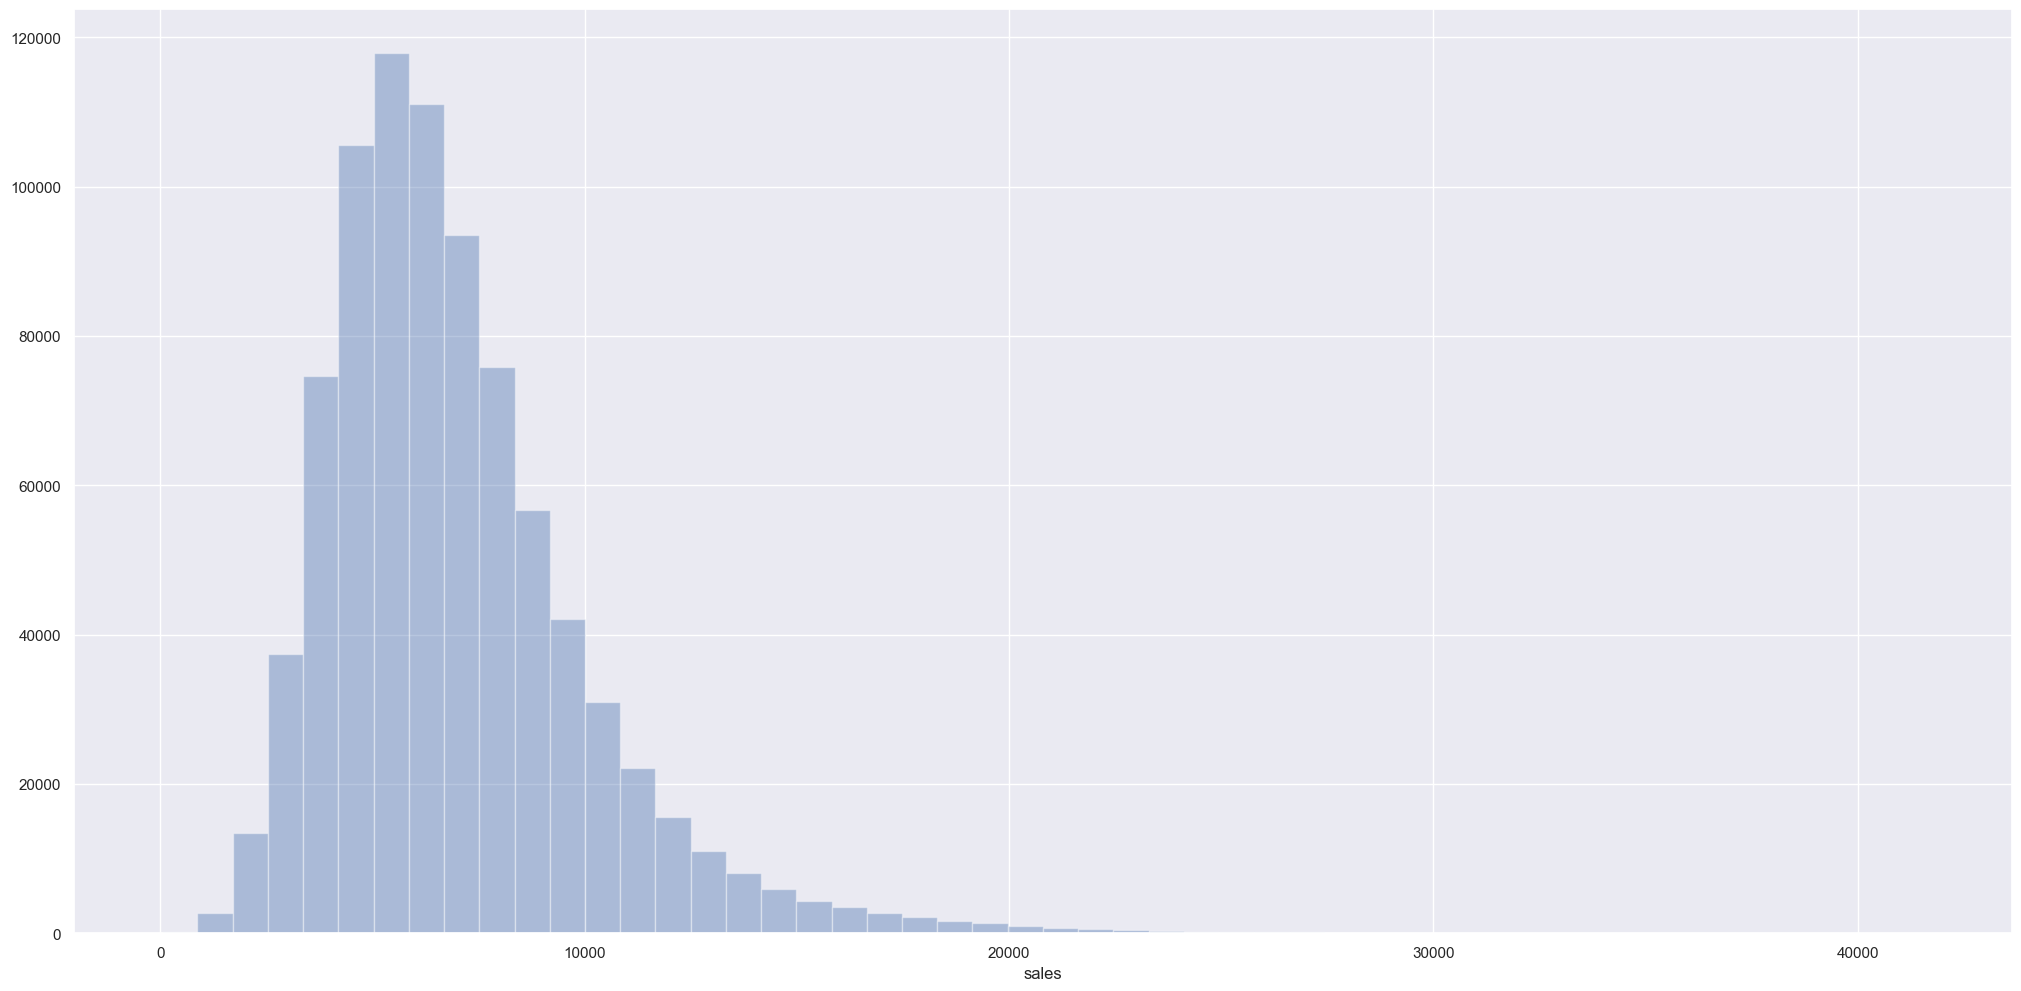

In [69]:
#Plot da densidade de distribuição do fenômeno que queremos prever
sns.distplot(df4['sales'],kde=False);

### 4.1.2 Numeric Variable

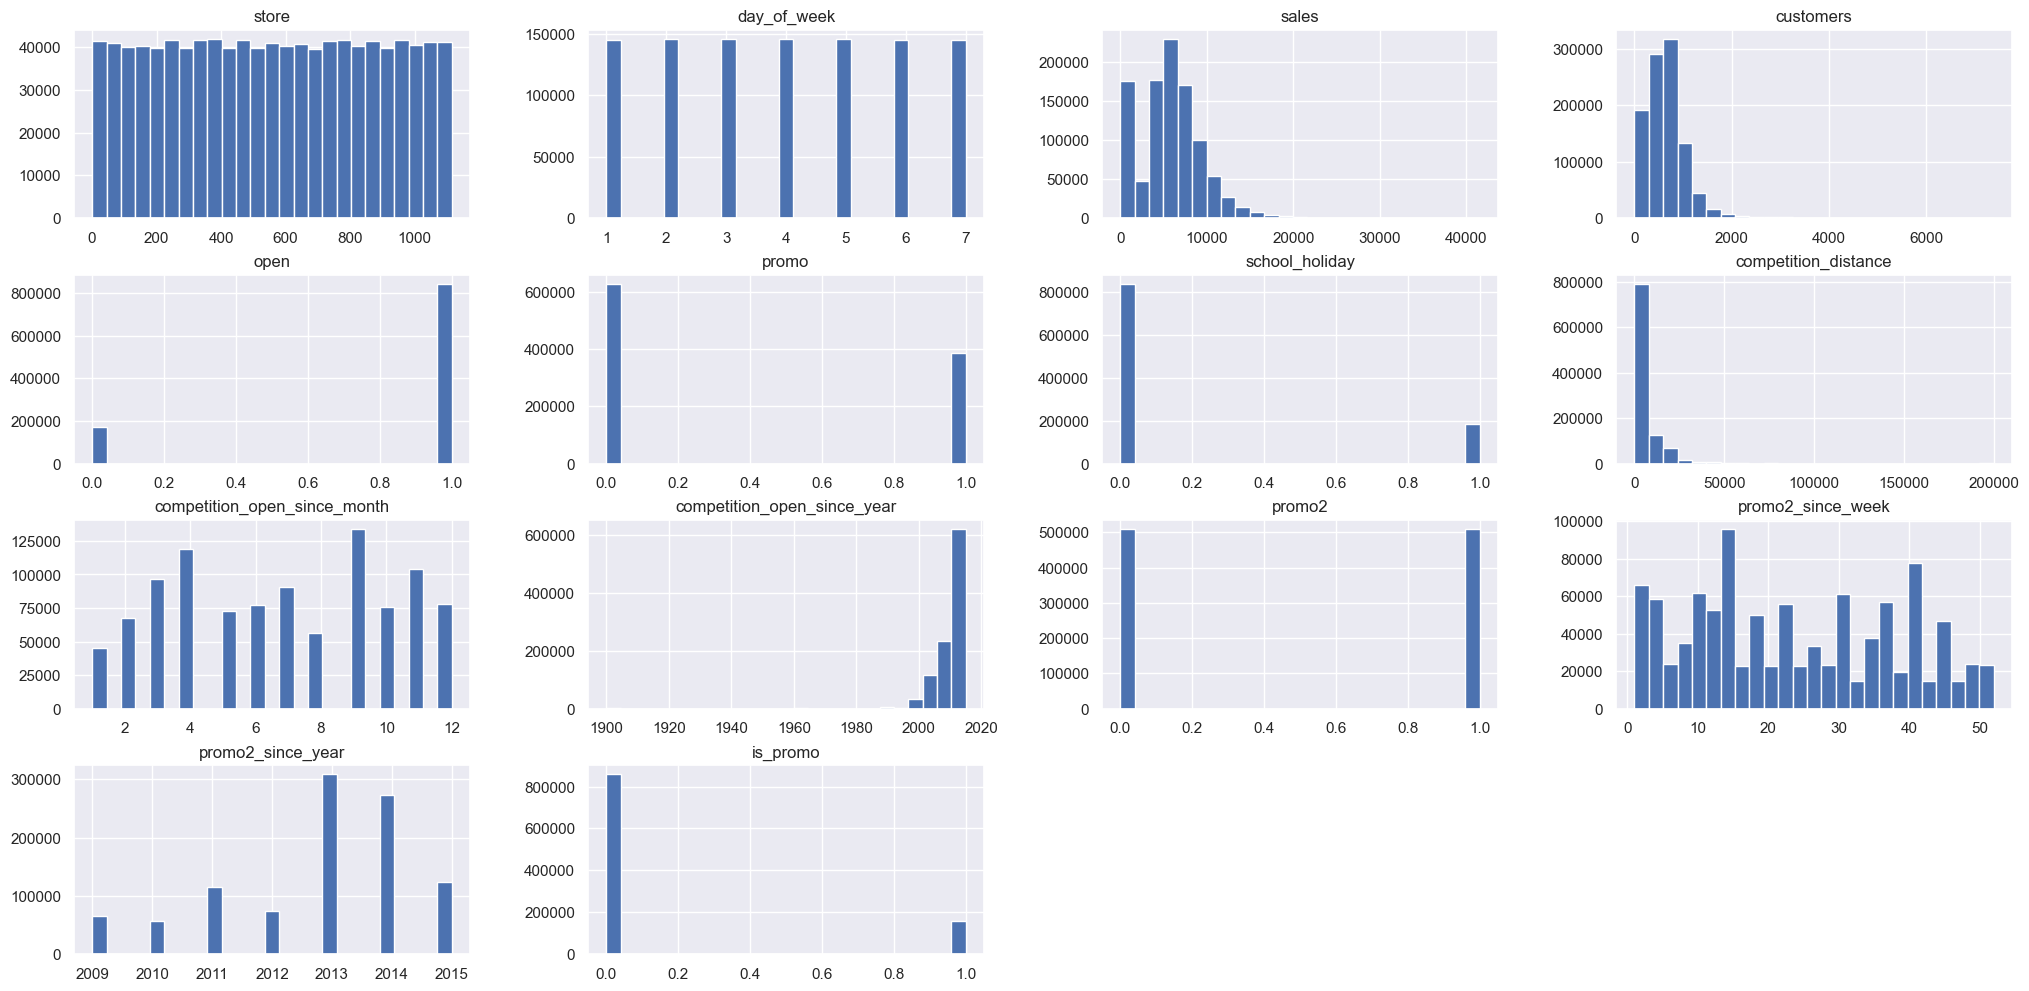

In [65]:
#Mostra a contagem das variáveis númericas, quantas vezes elas aparecem
#Com isso analisamos o compotamento das variáveis e o range das mesmas para tentar entender melhor os dados
num_atrr.hist(bins = 25);

### 4.1.3 Categorical Variable

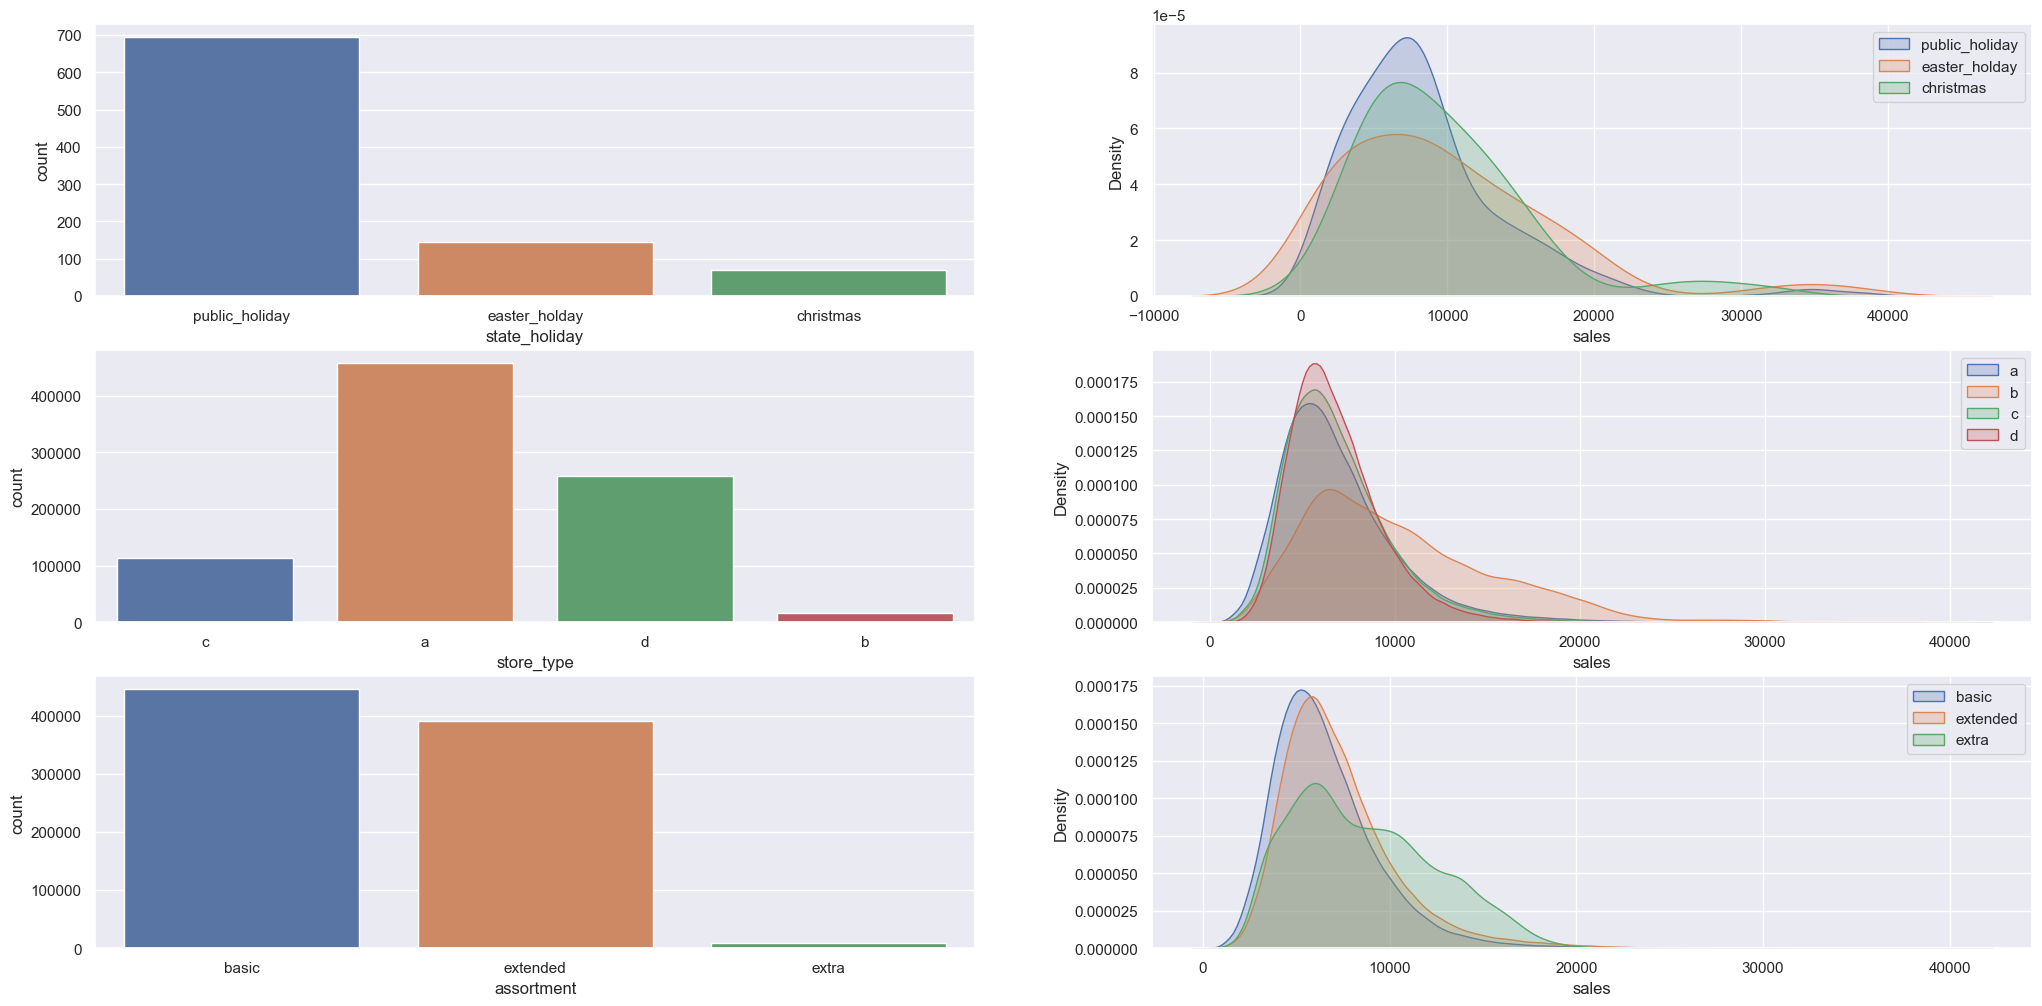

In [71]:
#Mostra a contagem das variáveis categóricas, quantas vezes elas aparecem e compara a densidade de vendas entre elas
#state_holiday
plt.subplot(3,2,1) #Contagem
aux_plot = df4[df4['state_holiday'] != 'regular_day'] #A maioria dos dias é regular_day, então tiramos ele para ter uma ideia das outras
sns.countplot( data=aux_plot['state_holiday'].reset_index(),x='state_holiday' );

plt.subplot(3,2,2) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holday']['sales'],label='easter_holday',shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas',shade=True);
plt.legend();

#store_type
plt.subplot(3,2,3)  #Contagem
sns.countplot( data=df4['store_type'].reset_index(),x='store_type' );

plt.subplot(3,2,4) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label='a',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label='b',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label='c',shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label='d',shade=True);
plt.legend();

#assortment
plt.subplot(3,2,5)  #Contagem
sns.countplot( data=df4['assortment'].reset_index(),x='assortment' );

plt.subplot(3,2,6) #Densidade das vendas com relação à variável
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label='basic',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label='extended',shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label='extra',shade=True);
plt.legend();

## 4.2 Análise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSO** Lojas com MAIOR sortimento vendem MENOS.

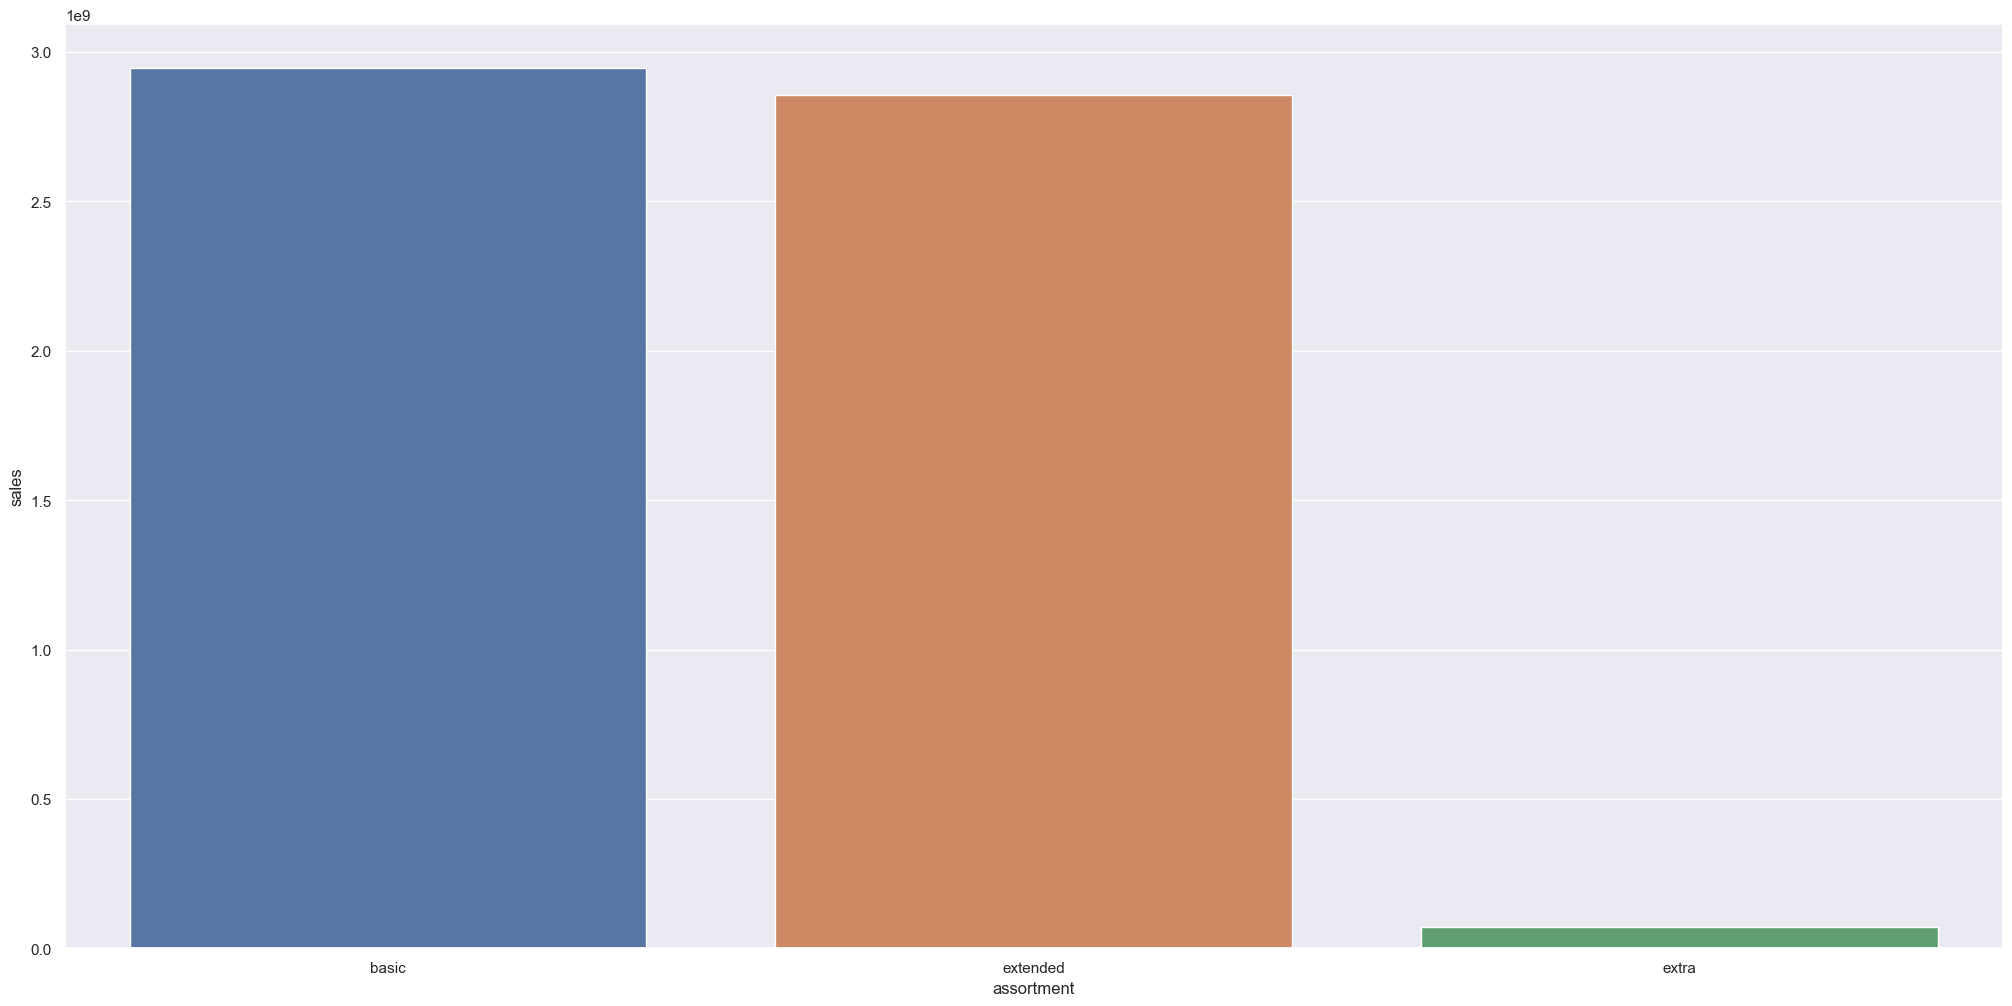

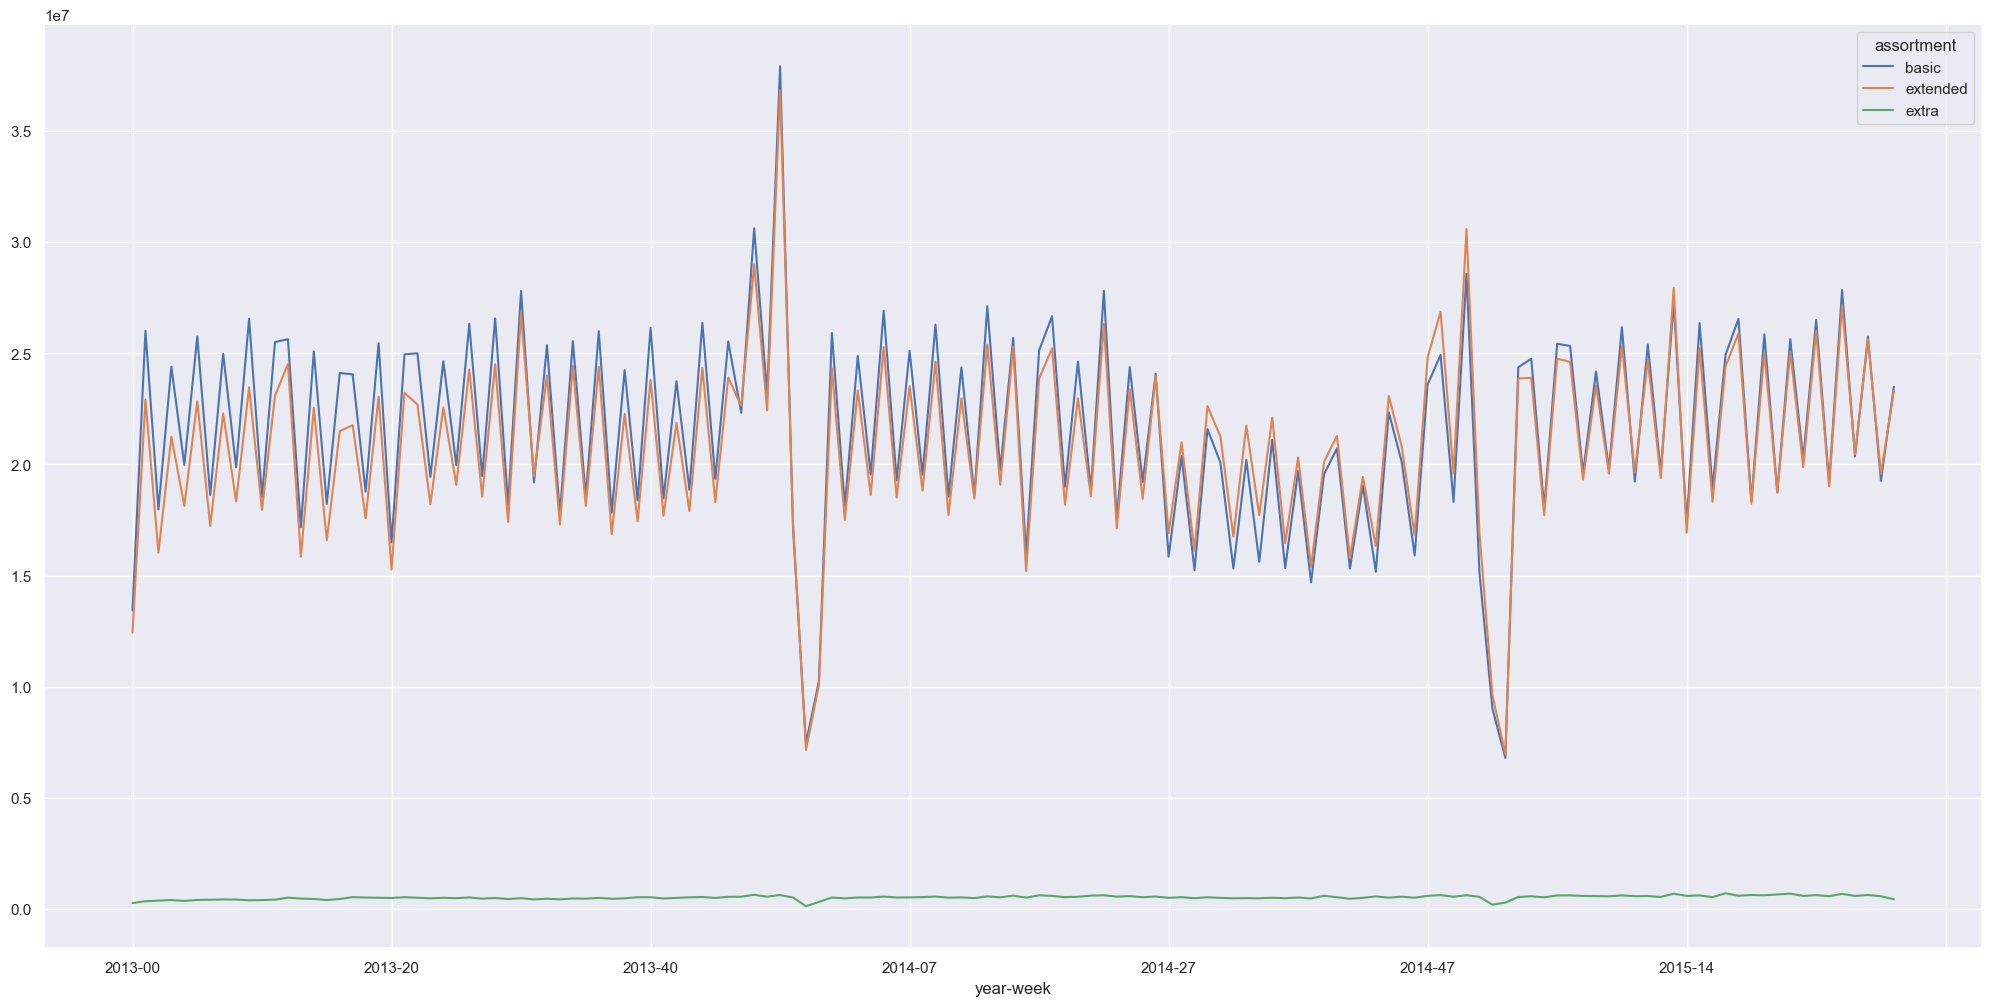

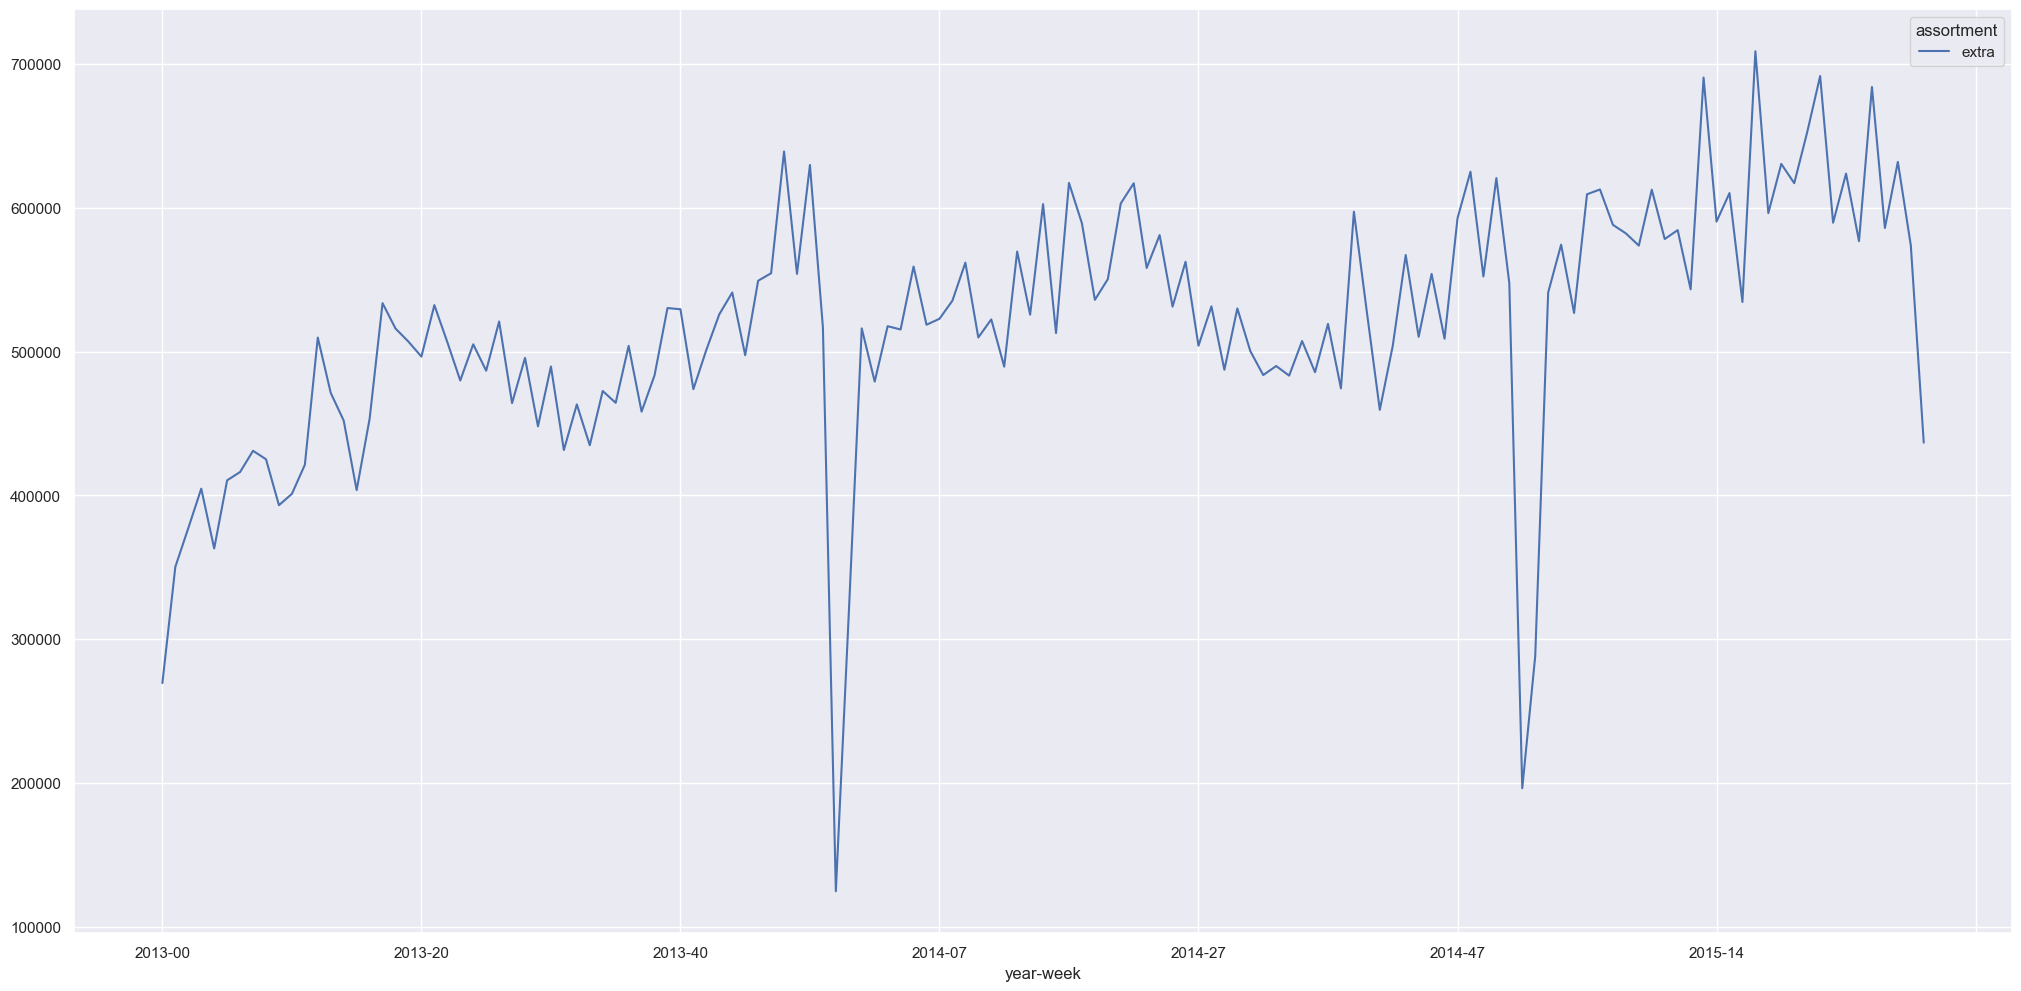

In [73]:
#Gráfico de barras das vendas por tipos de assortments
aux_1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux_1); #Relação entre assortments e sales

aux_2 = df4[['year-week','assortment','sales']].groupby(['year-week','assortment']).sum().reset_index()
aux_3 = aux_2.pivot(index='year-week',columns='assortment',values='sales')
aux_3.plot(); #Comportamento das vendas com relação às semanas dos anos

aux_4 = aux_2[aux_2['assortment'] == 'extra']
aux_5 = aux_4.pivot(index='year-week',columns='assortment',values='sales')
aux_5.plot(); #Comportamento apenas do sortimento extra

#Lojas com sortimento maior (extra) vendem menos
#Basic e extended são praticamente iguais em comportamento de vendas
#É relevante para o modelo pois mostra distinção de pelo menos uma variável com relação ao montante de vendas
#Basicamente, com o sortimento extra, vende menos, e sem ele vende mais, isso pode ser usado para prever as vendas

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSO** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

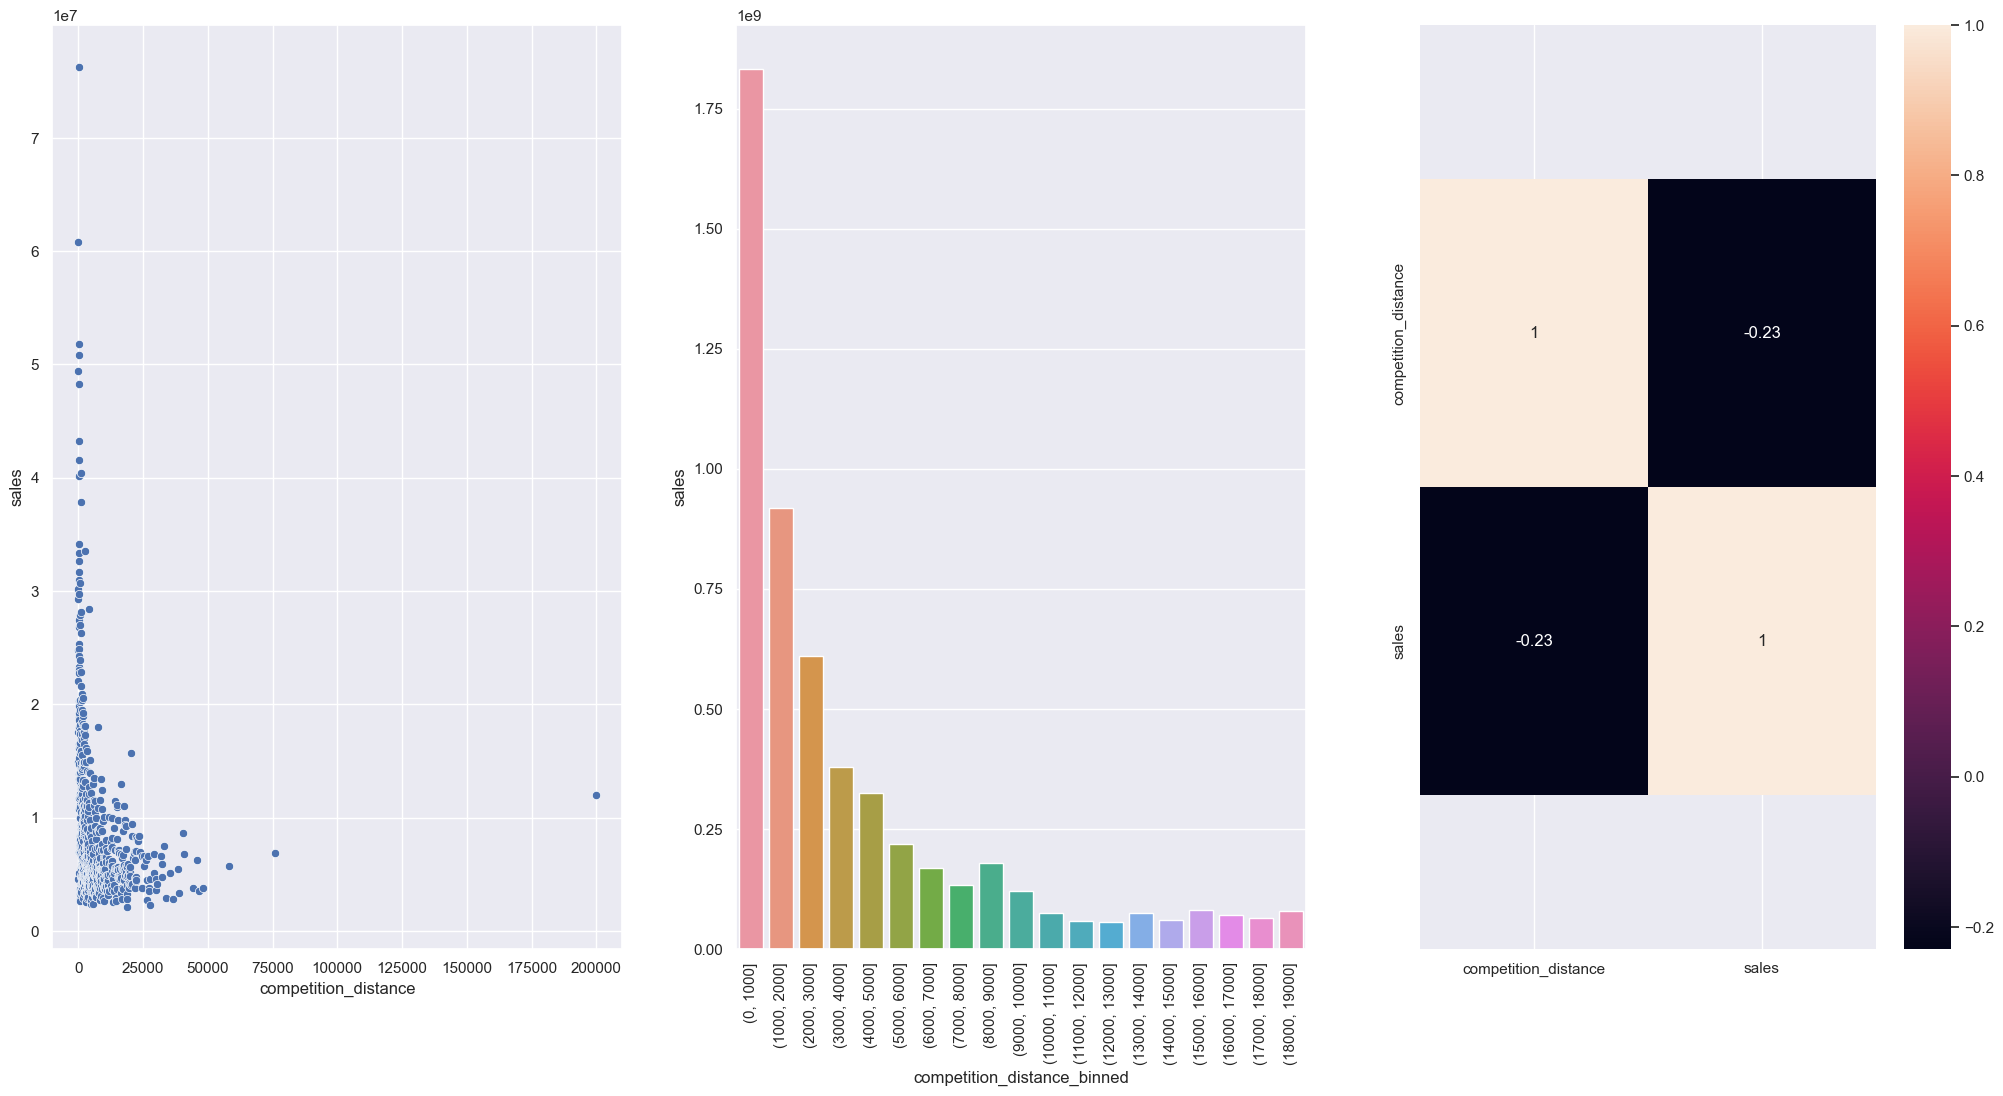

In [74]:
#bin - grupos de valores
aux_1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux_1);

#Vamos agrupar os resultados em grupos definidos pelos bins para melhorar a vizualização do gráfico
bins = list(np.arange(0,20000,1000))
#Cria os intervalos através de uma array e identifica cada valor em seu intervalo
#Coloca por exemplo, loja com competidores entre 0 e 1000 KM no mesmo intervalo e assim por diante
aux_1['competition_distance_binned'] = pd.cut(aux_1['competition_distance'],bins=bins)
aux_2 = aux_1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux_2);
plt.xticks(rotation=90); #Roda os rótulos do eixo x

#O heatmap mede a correlação entre as variáveis que vai de 1 até -1
#Como é -0.23,diz que quanto mais distante o concorrente está, menor a quantidade de vendas
plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['competition_distance','sales']].corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);


#Quanto mais próximo ao competidor, maior as vendas.

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSO** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS

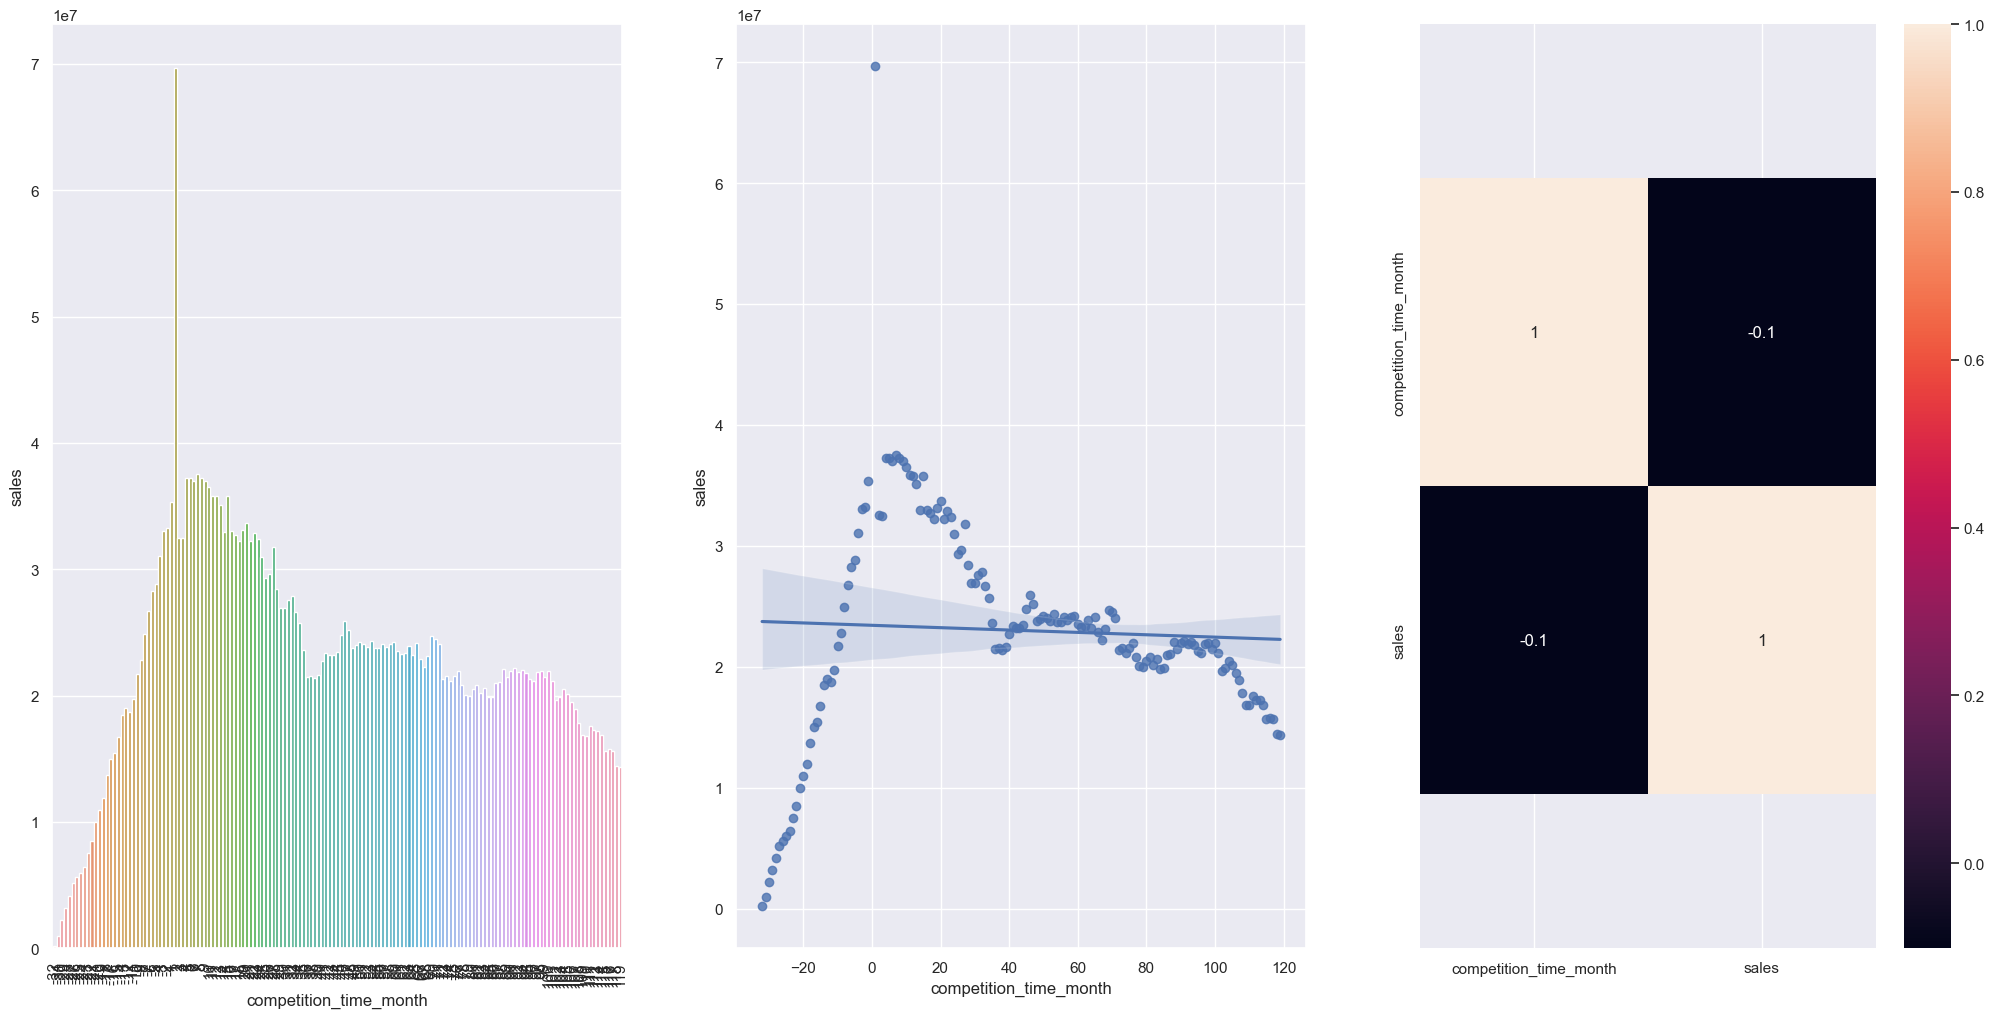

In [75]:
#Mês que o competidor começou
aux_1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux_2 = aux_1[(aux_1['competition_time_month'] < 120) & (aux_1['competition_time_month'] != 0)]
plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux_2);
plt.xticks(rotation=90); #Roda os rótulos do eixo x

#Compotamento de decaímento e crescimento
plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux_2);

plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['competition_time_month','sales']].corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

#Lojas com competidores a mais tempo vendem menos
#Quando uma competição está para ser iniciada, o número de vendas vai aumentando
#Correlação fraca com o modelo

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSO** Lojas com promoções ativas por MAIS tempo vendem MENOS, depois de um certo período de promoção.

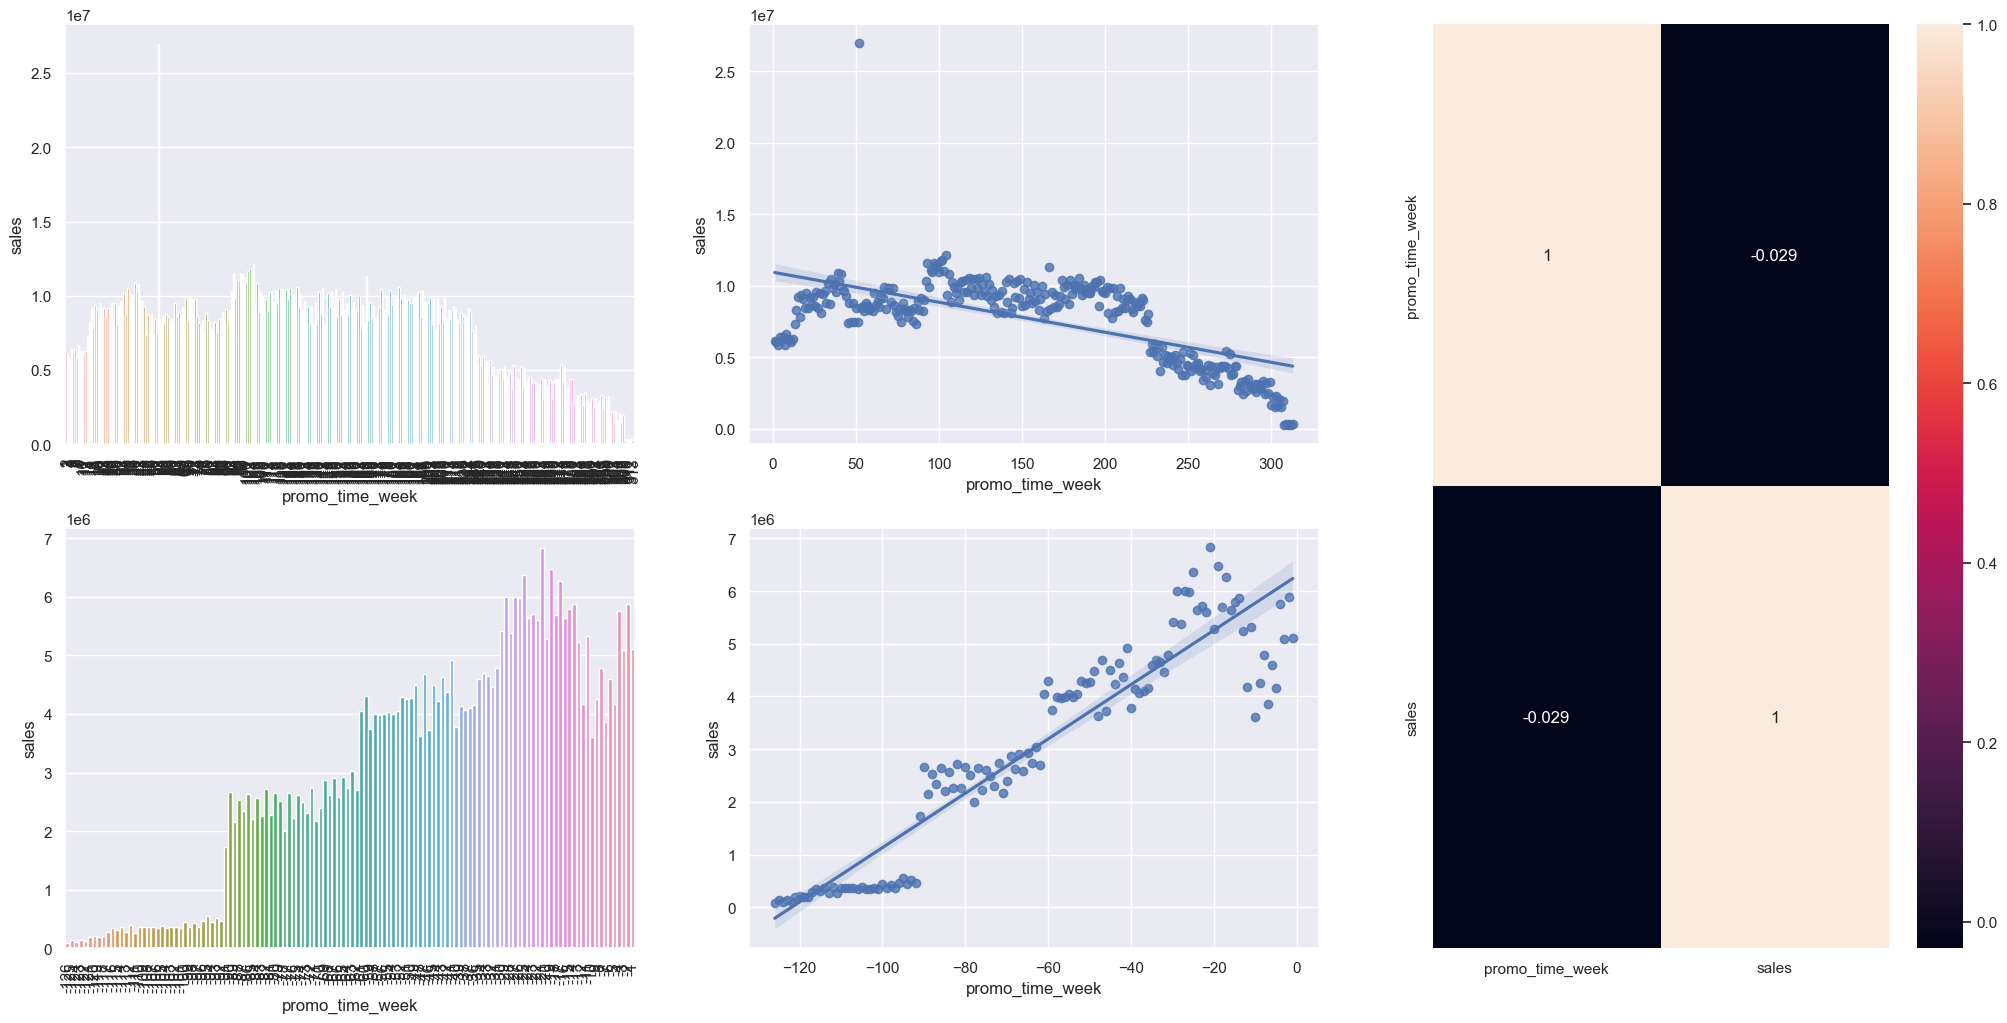

In [76]:
#'promo_time_week'- A quanto tempo essa promo está ativa, a quantas semanas
#promo_time_week negativo significa que a venda foi feita antes da promo extendida se iniciar, positivo, venda na promo.
aux_1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3) #Define o grid de plot dos gráficos, nessa caso, duas linhas, três colunas

plt.subplot(grid[0,0])
aux_2 = aux_1[aux_1['promo_time_week'] > 0]# período extendido da promo
sns.barplot(x='promo_time_week',y='sales',data=aux_2);
plt.xticks(rotation=90); #Roda os rótulos do eixo x

#O reg plot mostra a tendência dos dados, prova concreta se ele está numa crescende ou decrescente
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux_2);

plt.subplot(grid[1,0])
aux_3 = aux_1[aux_1['promo_time_week'] < 0]# período de promo regular
sns.barplot(x='promo_time_week',y='sales',data=aux_3);
plt.xticks(rotation=90); #Roda os rótulos do eixo x

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux_3);

plt.subplot(grid[:,2]) #Todas as linhas, terceira coluna
x = sns.heatmap( aux_1[['promo_time_week','sales']].corr( method='pearson' ), annot=True );

#Promo extendida mantém vendas constantes até certo período, ela não vende mais quanto mais tempo a promo está ativa.
#Correlação de -0.029 é fraca

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

In [77]:
#Validar no próximo ciclo

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSO** Lojas com promoções consectivas vendem MENOS.

In [78]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().sort_values('sales',ascending=False).reset_index()

#Podemos ver que a menor quantidade de vendas foi no período de promo extendido, sem a promo normal
#Sem promoção vendeu mais do que apenas na promoção extendida

,promo,promo2,sales
0,1,0,1628930532
1,0,0,1482612096
2,1,1,1472275754
3,0,1,1289362241


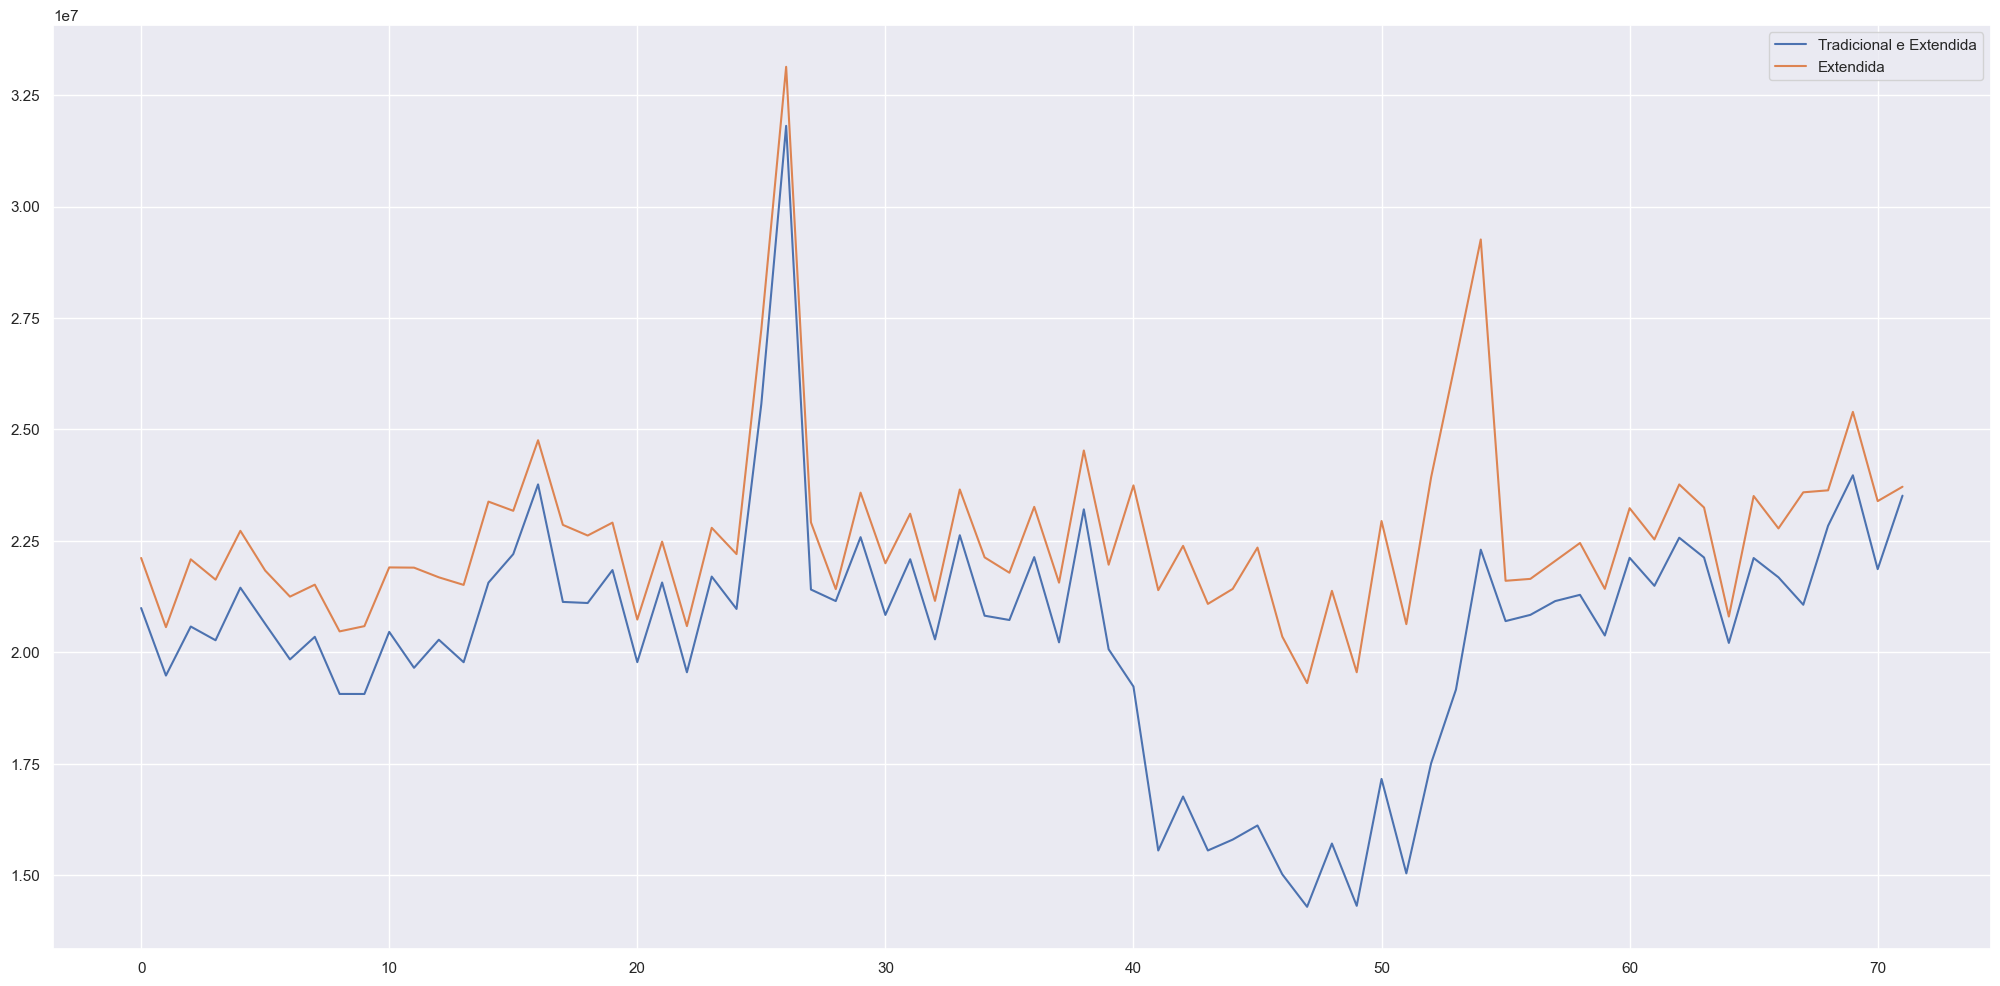

In [80]:
#Funciona como o loc, passando o filtro das linhas e depois quais colunas selecionar
aux_1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year-week','sales']].groupby('year-week').sum().reset_index()
ax = aux_1.plot();

aux_2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year-week','sales']].groupby('year-week').sum().reset_index()
aux_2.plot(ax=ax);

ax.legend(labels=['Tradicional e Extendida','Extendida']);

#Comportamento de vendas quando está na promo extendida é muito parecida com quando tinha promo normal e foi pra extendida
#Na promo extendida vende um pouco mais, mas nem tanto, então promoções consecutivas não fazem vender mais

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas abertas durante o feriado de Natal vendem MENOS.

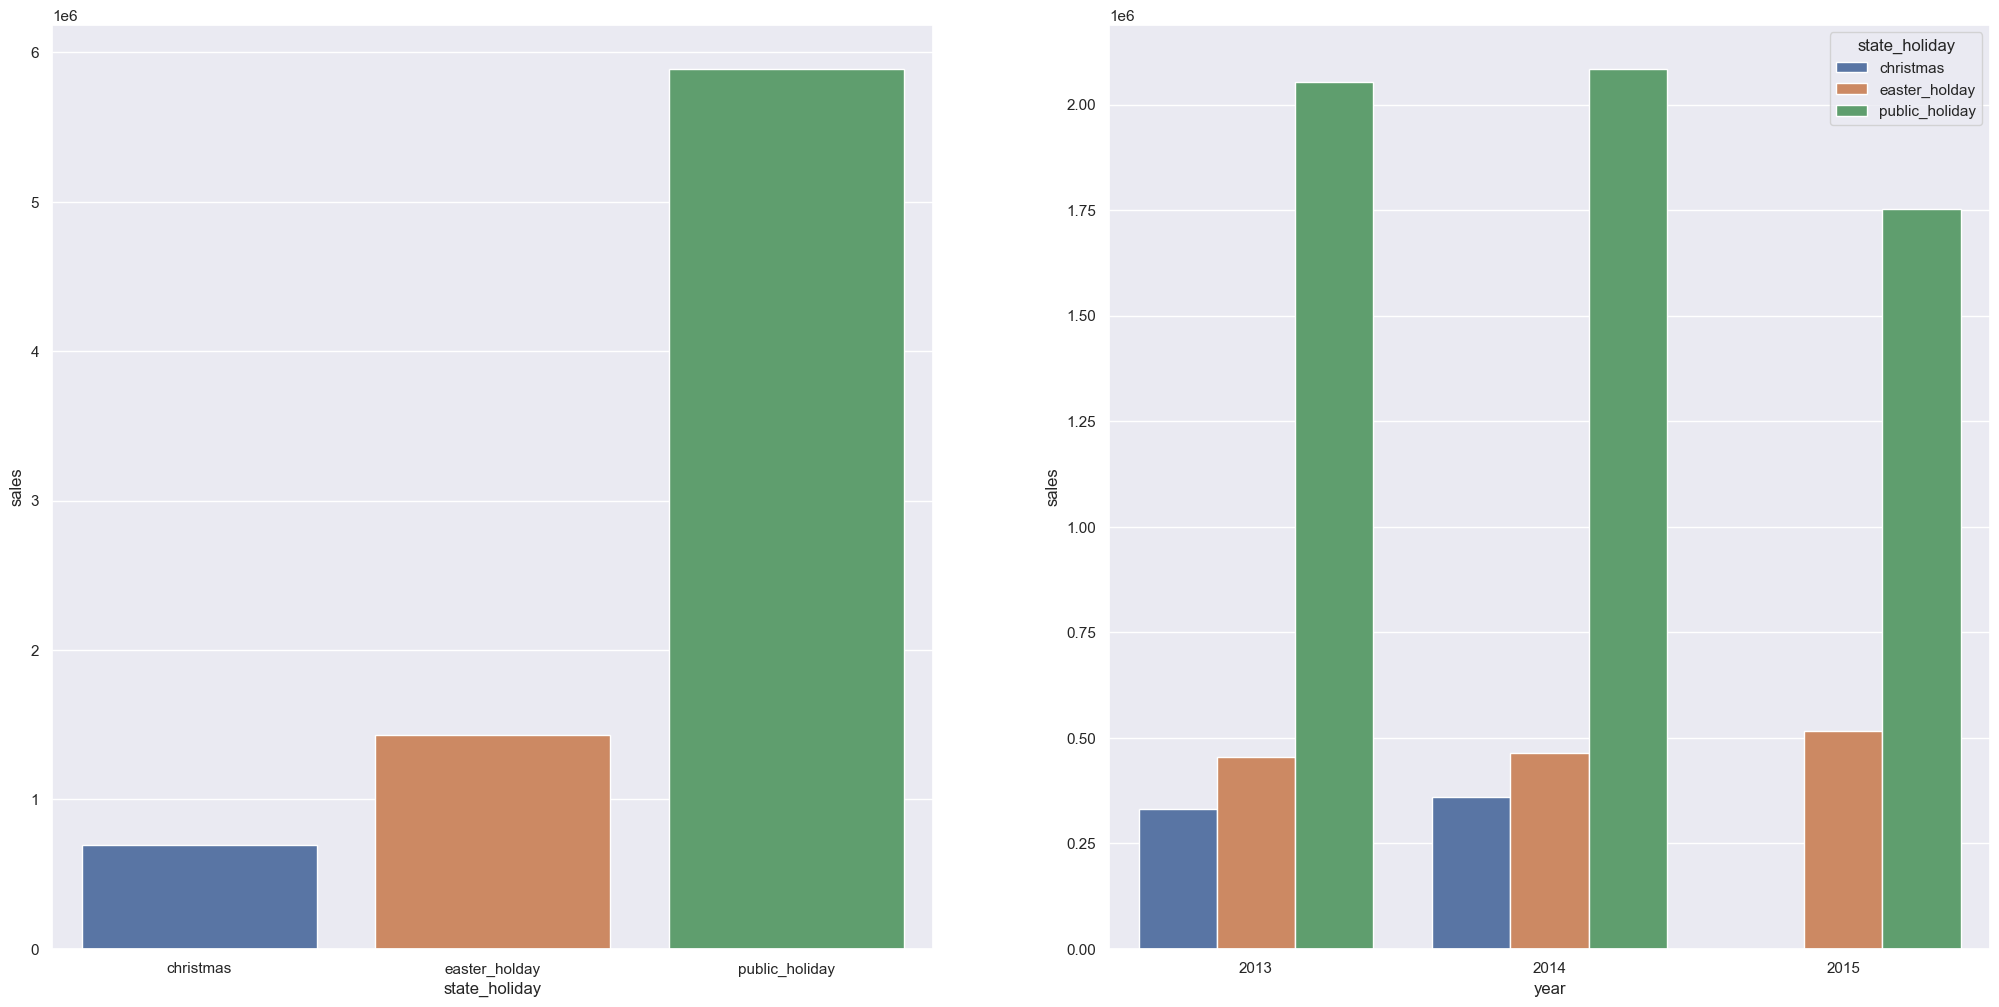

In [81]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux_1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data=aux_1);

#Venda no Natal ao longo do tempo, agrupando e somando as vendas por ano e feriado
aux_2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux_2);

#Lojas abertas durante o Natal vendem menos que os outros feriados
#Passando pelos anos, vemos que em todos os anos, no Natal vende menos que os outros feriados

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSO** Lojas vendem MENOS ao longo dos anos.

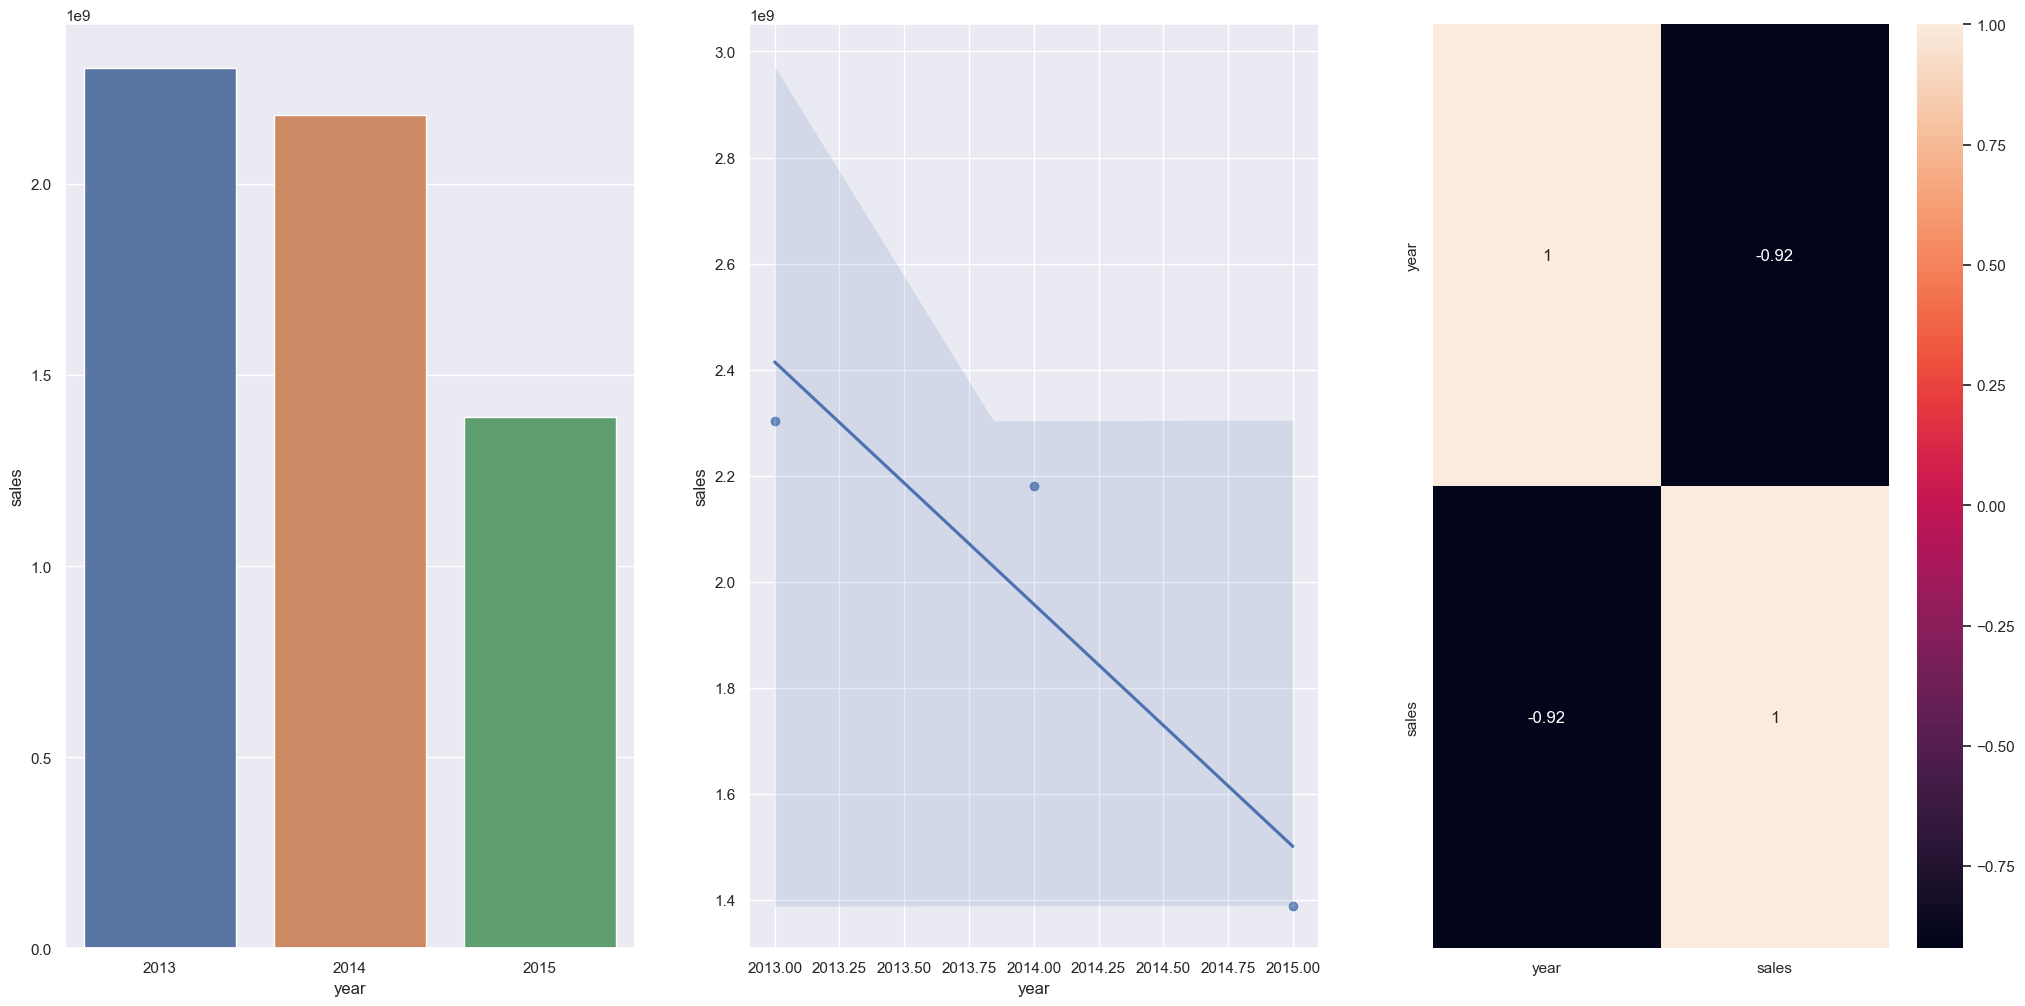

In [82]:
#Soma das vendas no decorrer dos anos
aux_1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux_1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux_1);

plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['year','sales']].corr( method='pearson' ), annot=True );

#Vendas vem caindo com o passar dos anos, tendência do regplot decrescente
#Corelação com força alta, perto de -1, ano é uma variável importante para o modelo
#Pelo ano de 2015 não ter dados completos, acentua-se a curva decrescente

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas vendem MENOS no segundo semestre do ano.

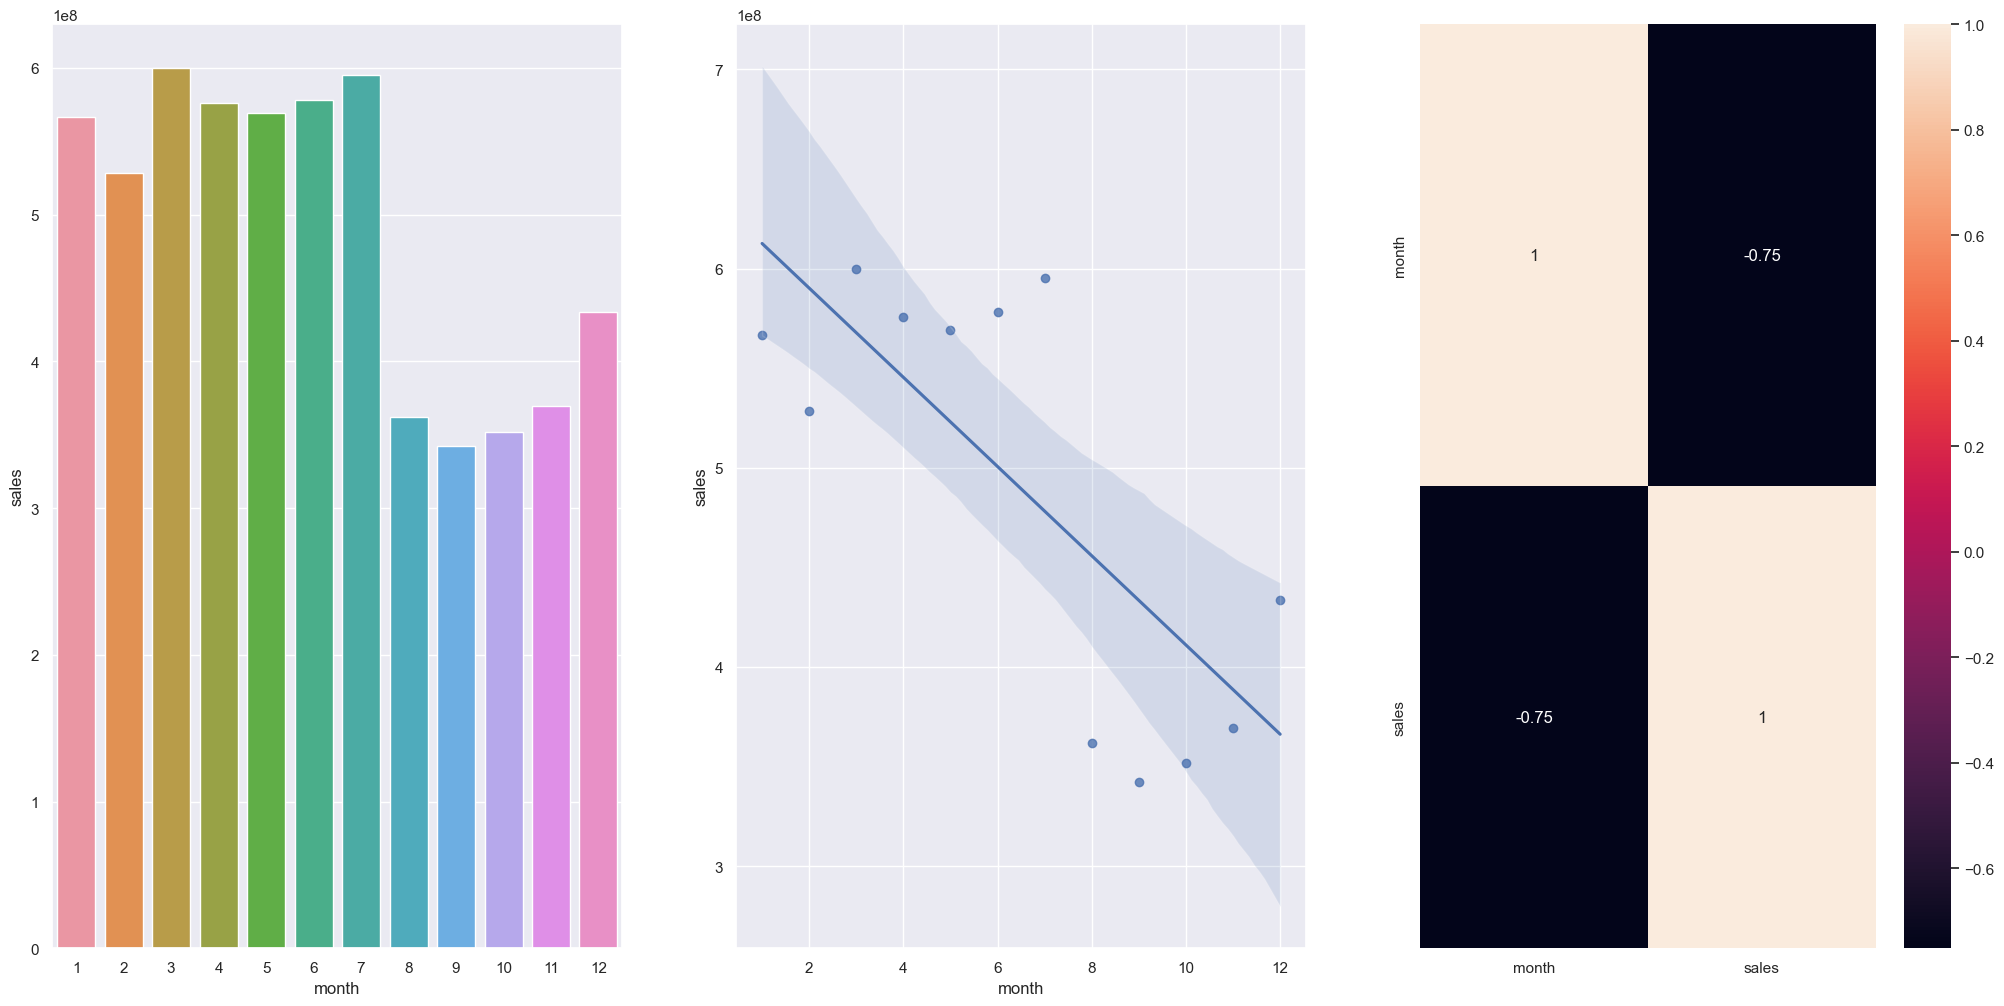

In [83]:
#Soma das vendas no decorrer dos meses
aux_1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux_1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux_1);

plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['month','sales']].corr( method='pearson' ), annot=True );

#Lojas vendem menos no segundo semestre do ano
#Curva decrescente de densidade de vendas com o passar dos meses do ano
#Correlação forte de -0.75, variável importante que influencia e faz as vendas cair quando relacionadas ao segundo semestre

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRO** Lojas vendem MAIS depois do dia 10 de cada mês

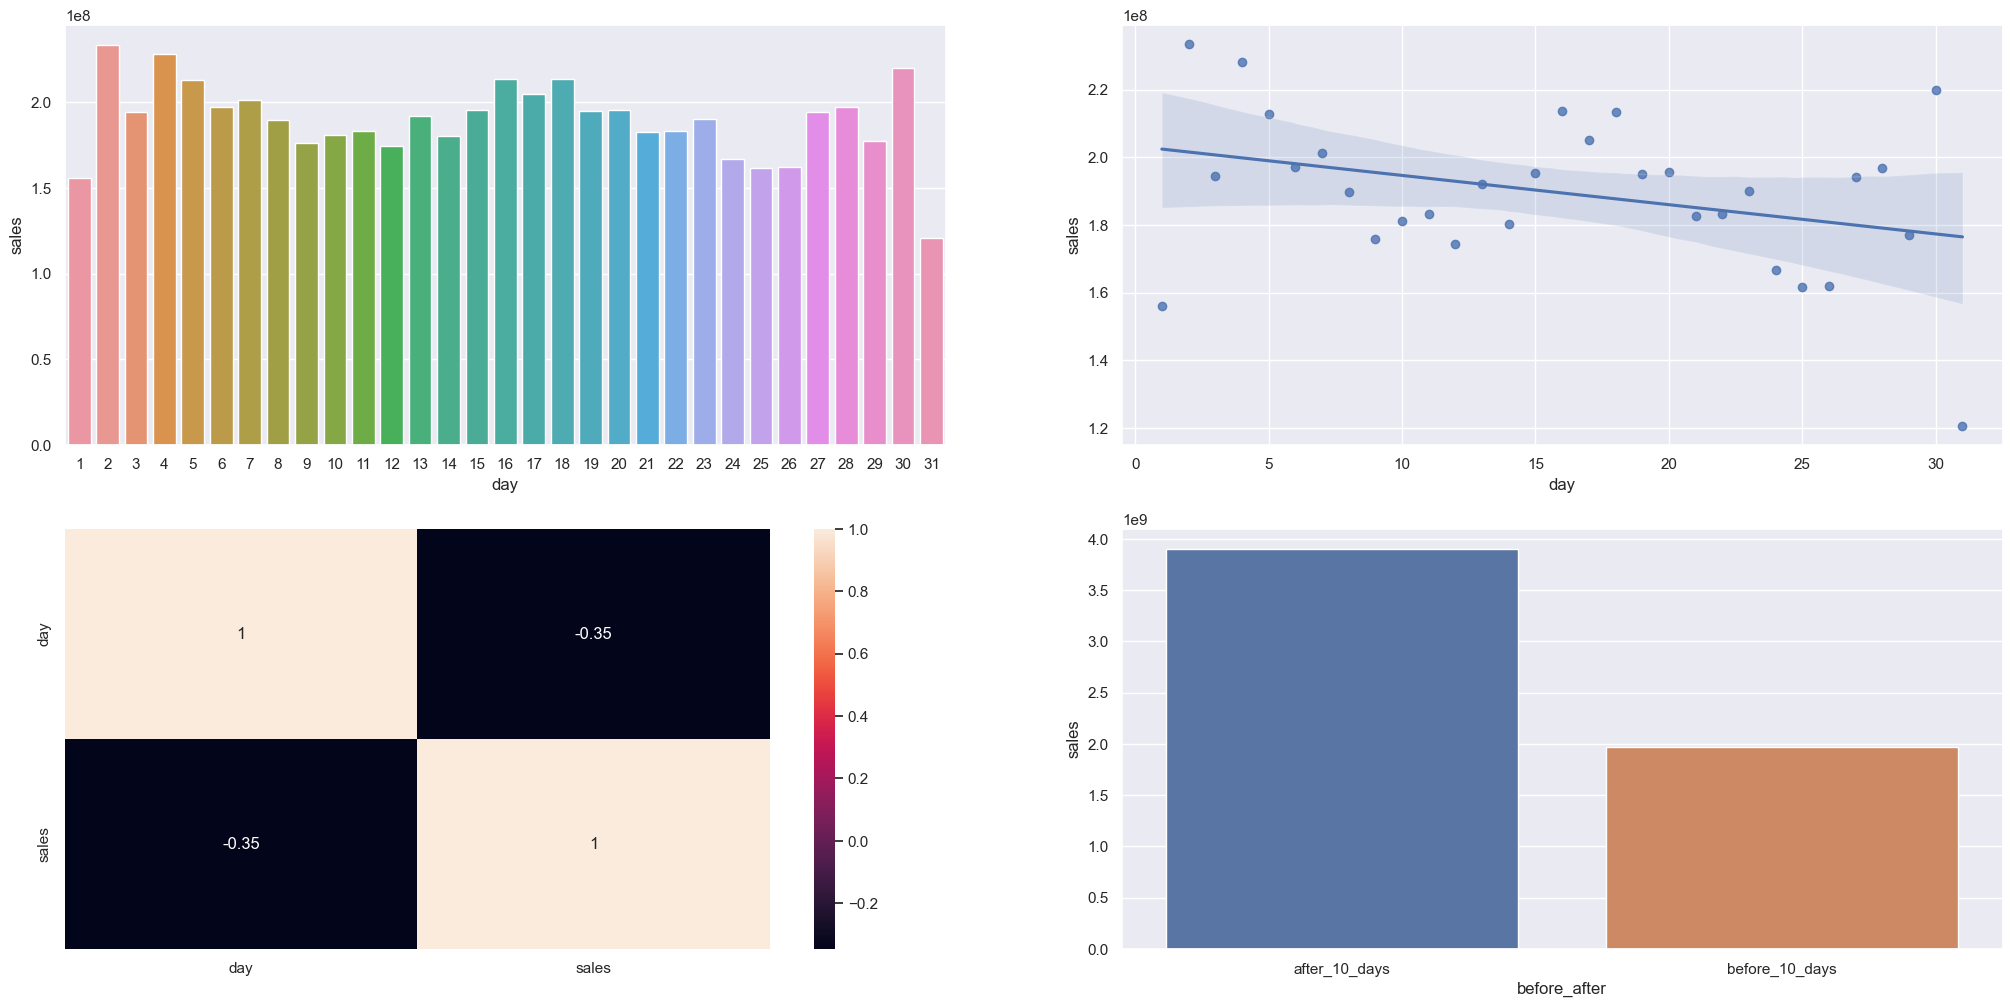

In [84]:
#Soma das vendas no decorrer dos dias
aux_1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux_1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux_1);

plt.subplot(2,2,3)
x = sns.heatmap( aux_1[['day','sales']].corr( method='pearson' ), annot=True );

aux_1['before_after'] = aux_1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux_2 = aux_1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux_2);

#Com o passar dos dias do mês as vendas caem
#Correlação média, e com tendência negativa
#As lojas vendem mais depois do dia 10, até porque o período de tempo é maior

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas vendem MENOS aos finais de semana.

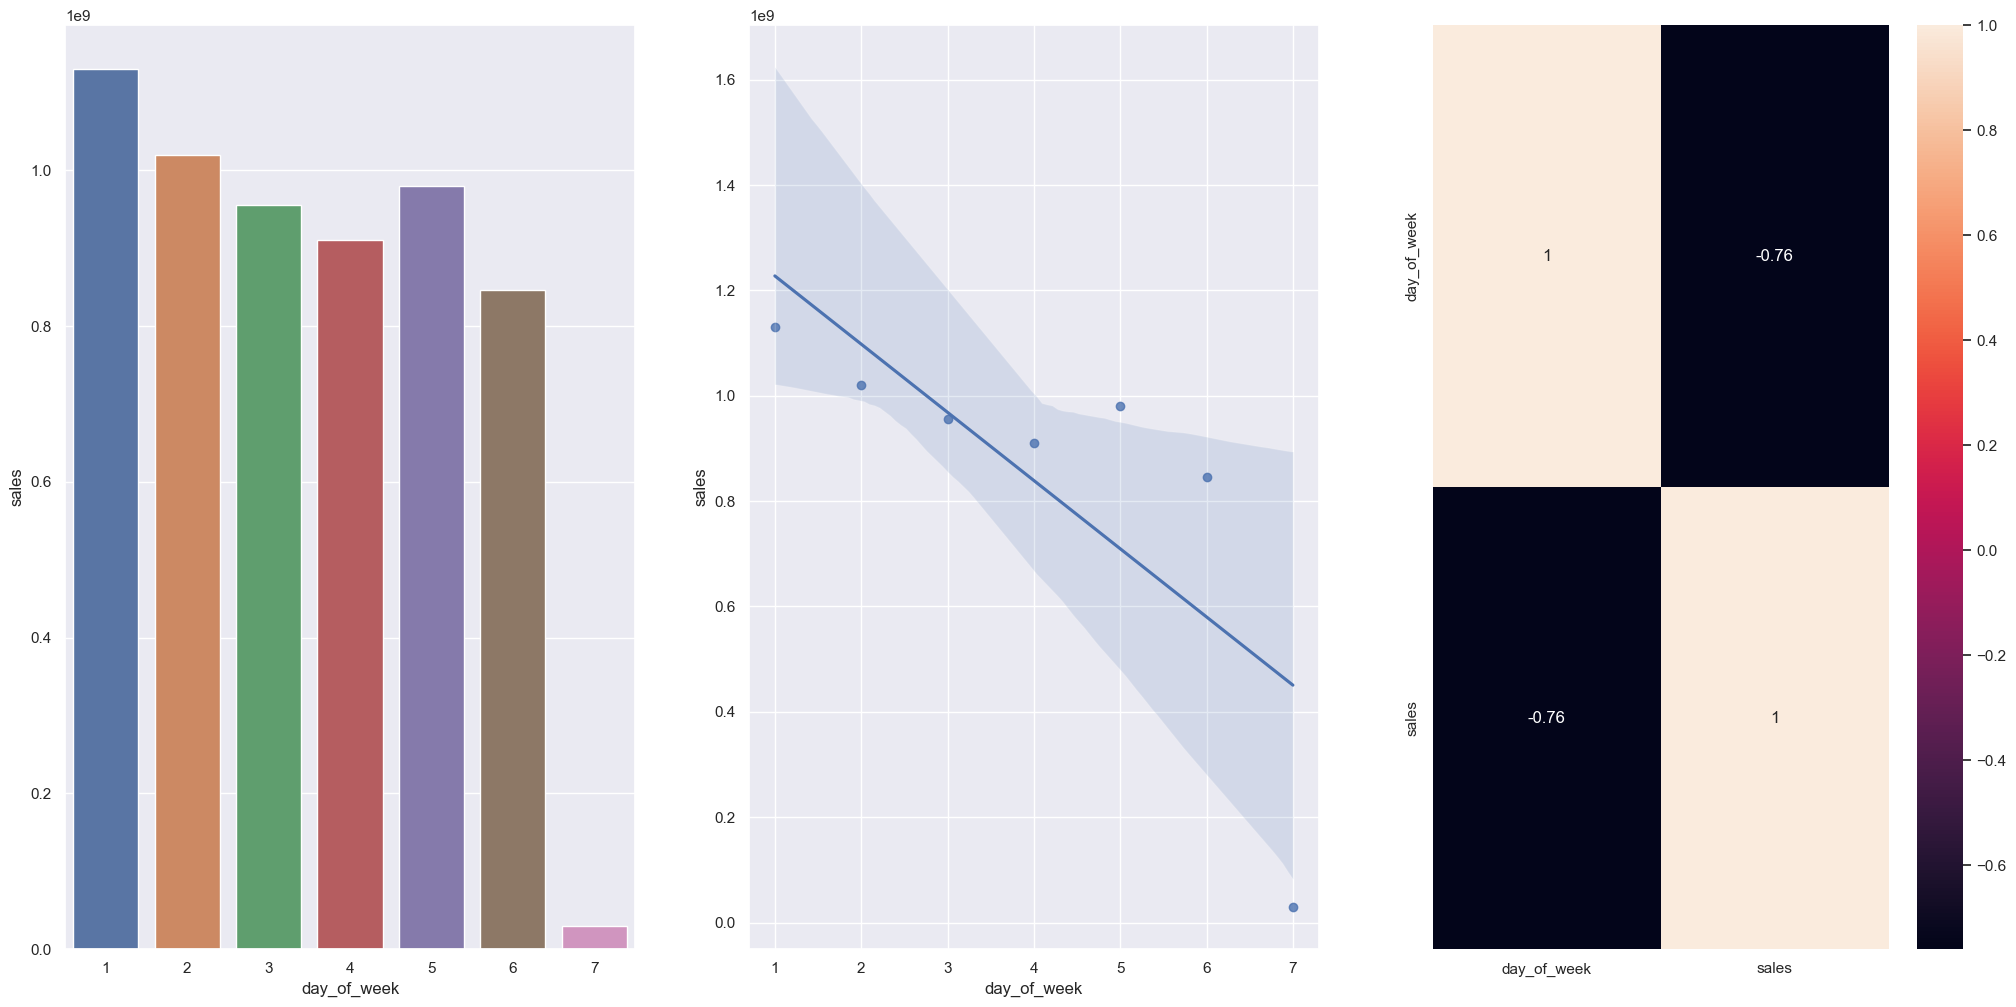

In [85]:
#Soma das vendas no decorrer dos dias da semana
aux_1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux_1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux_1);

plt.subplot(1,3,3)
x = sns.heatmap( aux_1[['day_of_week','sales']].corr( method='pearson' ), annot=True );

#Correlação negativa alta
#Com o passar dos dias as vendas caem, e no fim de semana é pior, sábado vende menos que os outros dias e domingo é o pior.
#Tendência de cair as vendas com o passar dos dias da semana

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRO** Lojas vendem MENOS durante os feriados escolares, exceto os meses de julho e agosto.

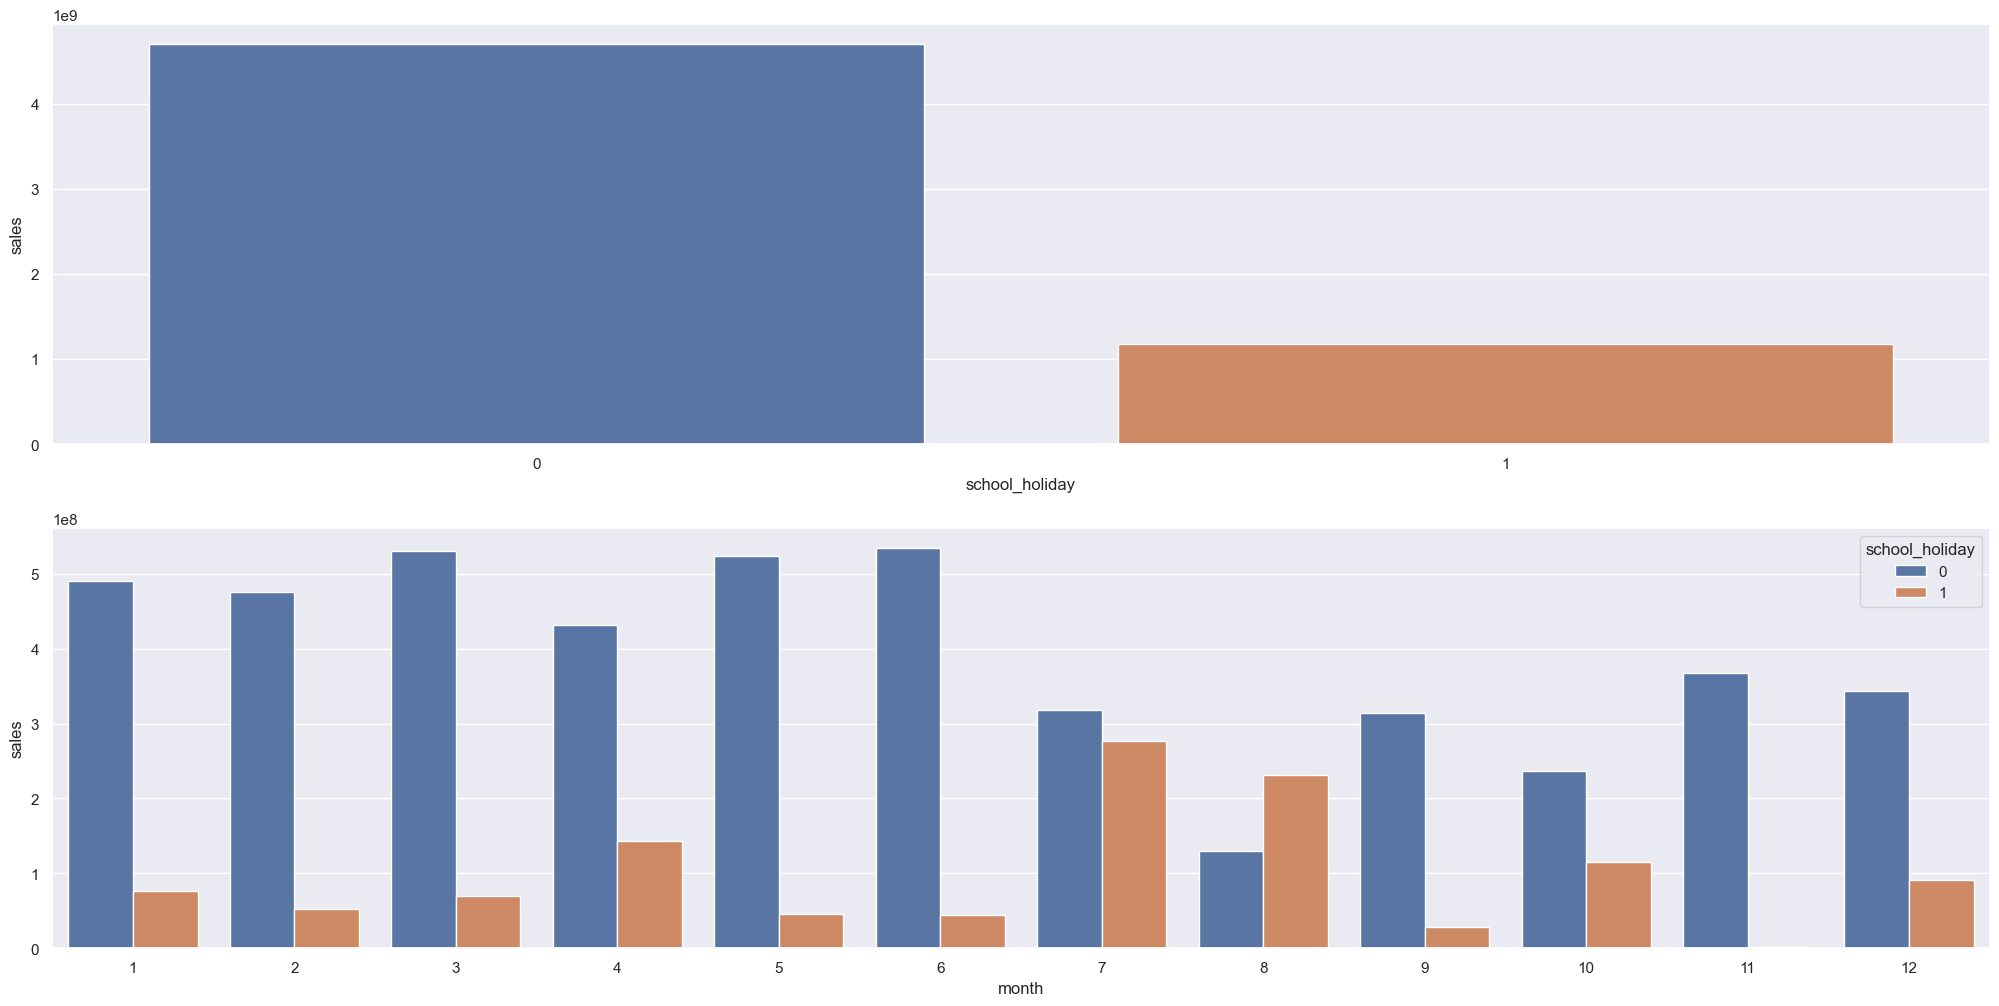

In [86]:
#Agrupar as vendas por feriados escolares e verificar se vendem mais ou não nesse período
aux_1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux_1);

plt.subplot(2,1,2)
aux_2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(hue='school_holiday',x='month',y='sales',data=aux_2);

#Durante as férias escolares, as vendas acabam se equiparando, até porque a maioria dos dias é feriado escolar
#No geral as lojas vendem menos durante os feriados escolares

## 4.2.1 Resumo das Hipóteses

In [88]:
#Resumo um geral da relevância das hipóteses para o modelo a partir da análise exploratória de dados bivariada.
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Media'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10', 'Verdadeira', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise Multivariada

In [91]:
num_atrr = df4.select_dtypes(include=['int64','float64'])
cat_atrr = df4.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 4.3.1 Numerical Attibutes

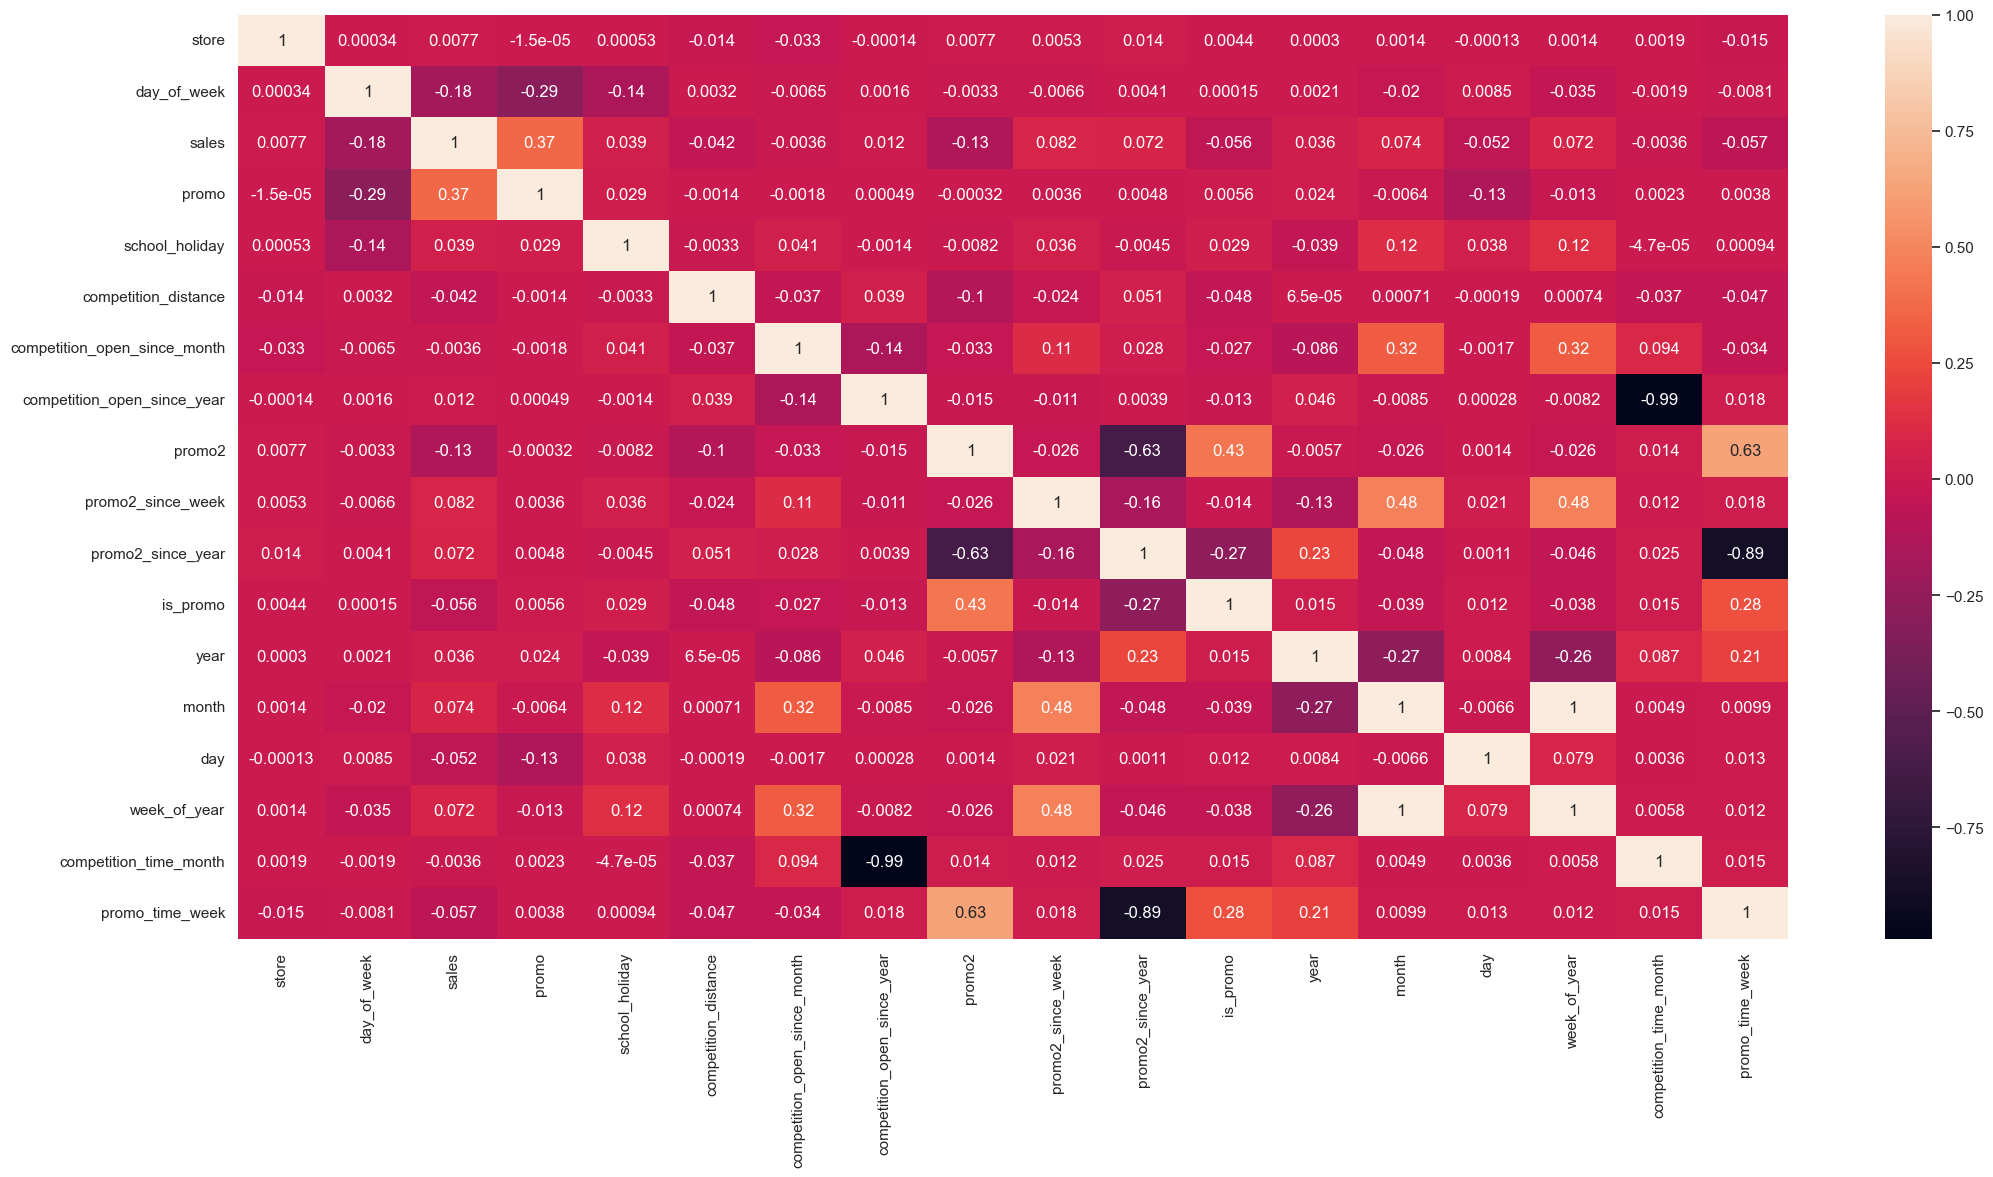

In [92]:
#Vemos a correlação das variáveis numéricas entre elas mesmas
correlation = num_atrr.corr(method='pearson')
sns.heatmap( correlation, annot=True );

#Correlação das variáveis com ela mesmo é sempre 1
#Interessante focar na correlação dessas variáveis com o fenômenos que buscamos - sales

### 4.3.2 Categorical Attibutes

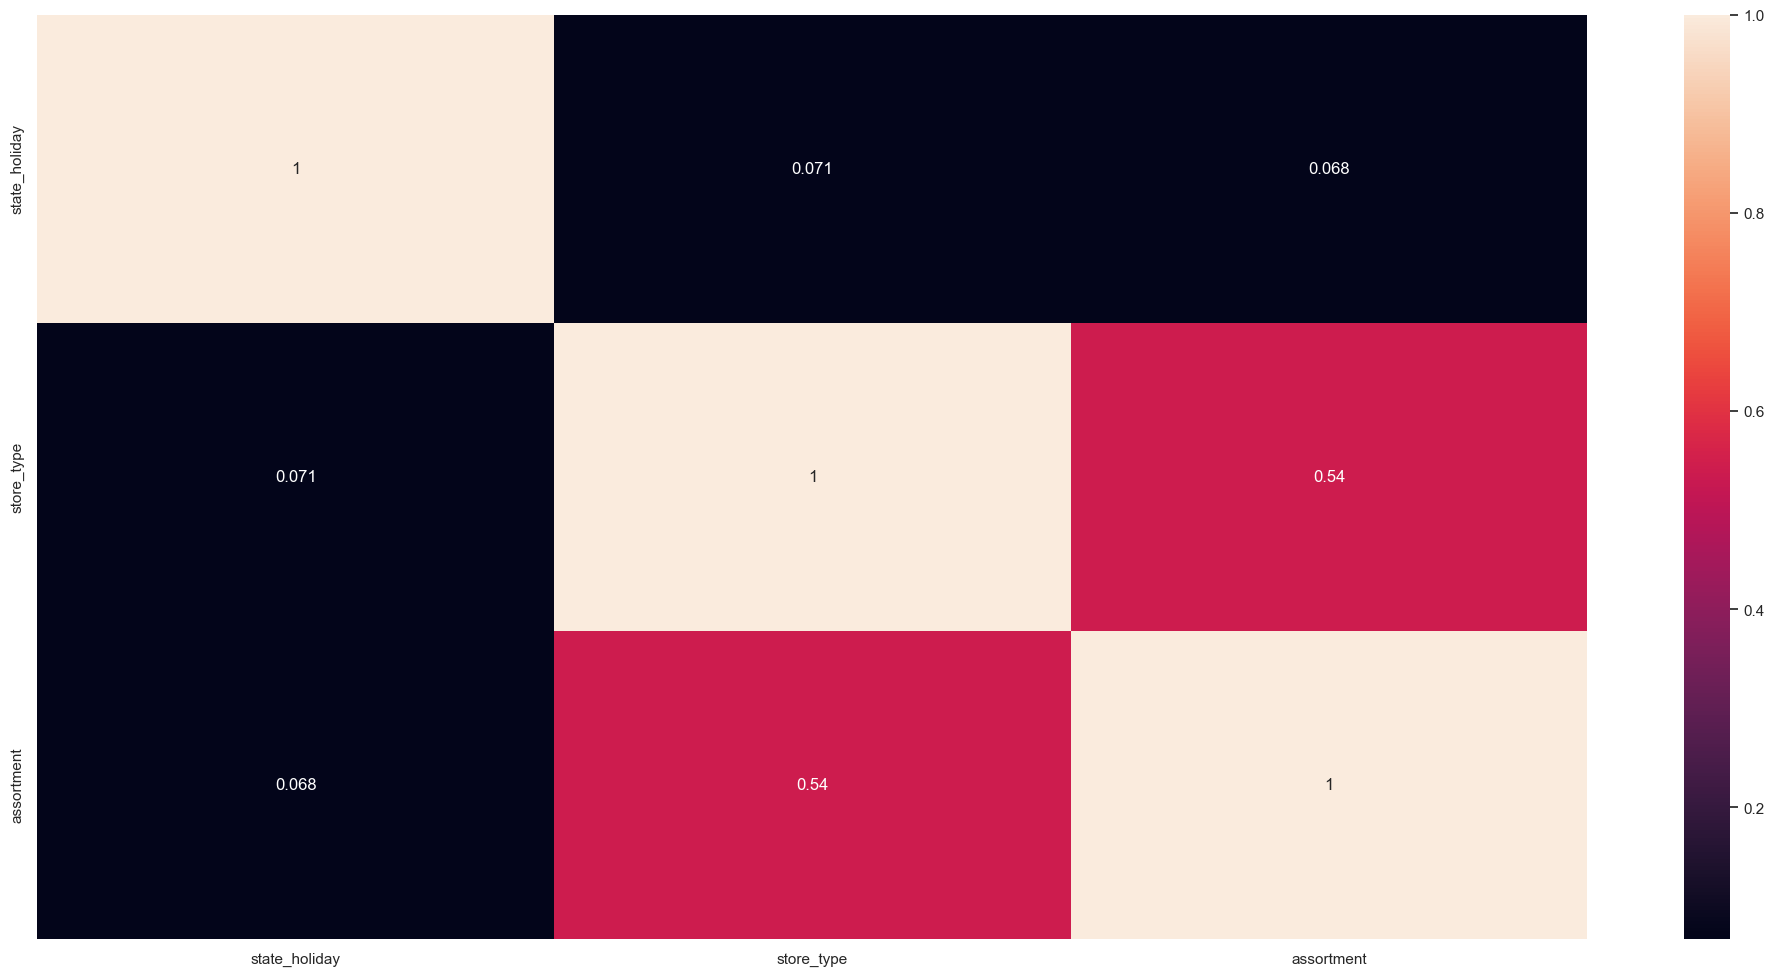

In [93]:
#Criando a relação entre as variáveis categóricas
#Cálculos do Cramer's V
a1 = cramer_v(cat_atrr['state_holiday'],cat_atrr['state_holiday'])
a2 = cramer_v(cat_atrr['state_holiday'],cat_atrr['store_type'])
a3 = cramer_v(cat_atrr['state_holiday'],cat_atrr['assortment'])

a4 = cramer_v(cat_atrr['store_type'],cat_atrr['state_holiday'])
a5 = cramer_v(cat_atrr['store_type'],cat_atrr['store_type'])
a6 = cramer_v(cat_atrr['store_type'],cat_atrr['assortment'])

a7 = cramer_v(cat_atrr['assortment'],cat_atrr['state_holiday'])
a8 = cramer_v(cat_atrr['assortment'],cat_atrr['store_type'])
a9 = cramer_v(cat_atrr['assortment'],cat_atrr['assortment'])

#Dataset final entre as relações das variáveis categóricas
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap(d,annot=True);

#Assortment com relação alta com store_type, quanto maior o tipo da loja, mais produtos posso ter.

# 5.0 Data Preparation

In [94]:
#Cópia de segurança 5
df5 = df4.copy()

## 5.1 Normalização

In [95]:
#Na Análise univariável das variáveis não temos nenhuma com comportamento normal, por tal, não faremos a normalização.
#Podemos ver isso no primeiro snippet do capítulo 4.1.1.

## 5.2 Rescaling
Mesmos dados, no mesmo formato, em escala normalizada.

In [96]:
#Selecionando as variáveis numéricas do df
a = df5.select_dtypes(include=['int64','float64'])

In [97]:
#Vizualizando elas para ver quais podemos usar o reescaling
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,30,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,30,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,30,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,30,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,30,4,0


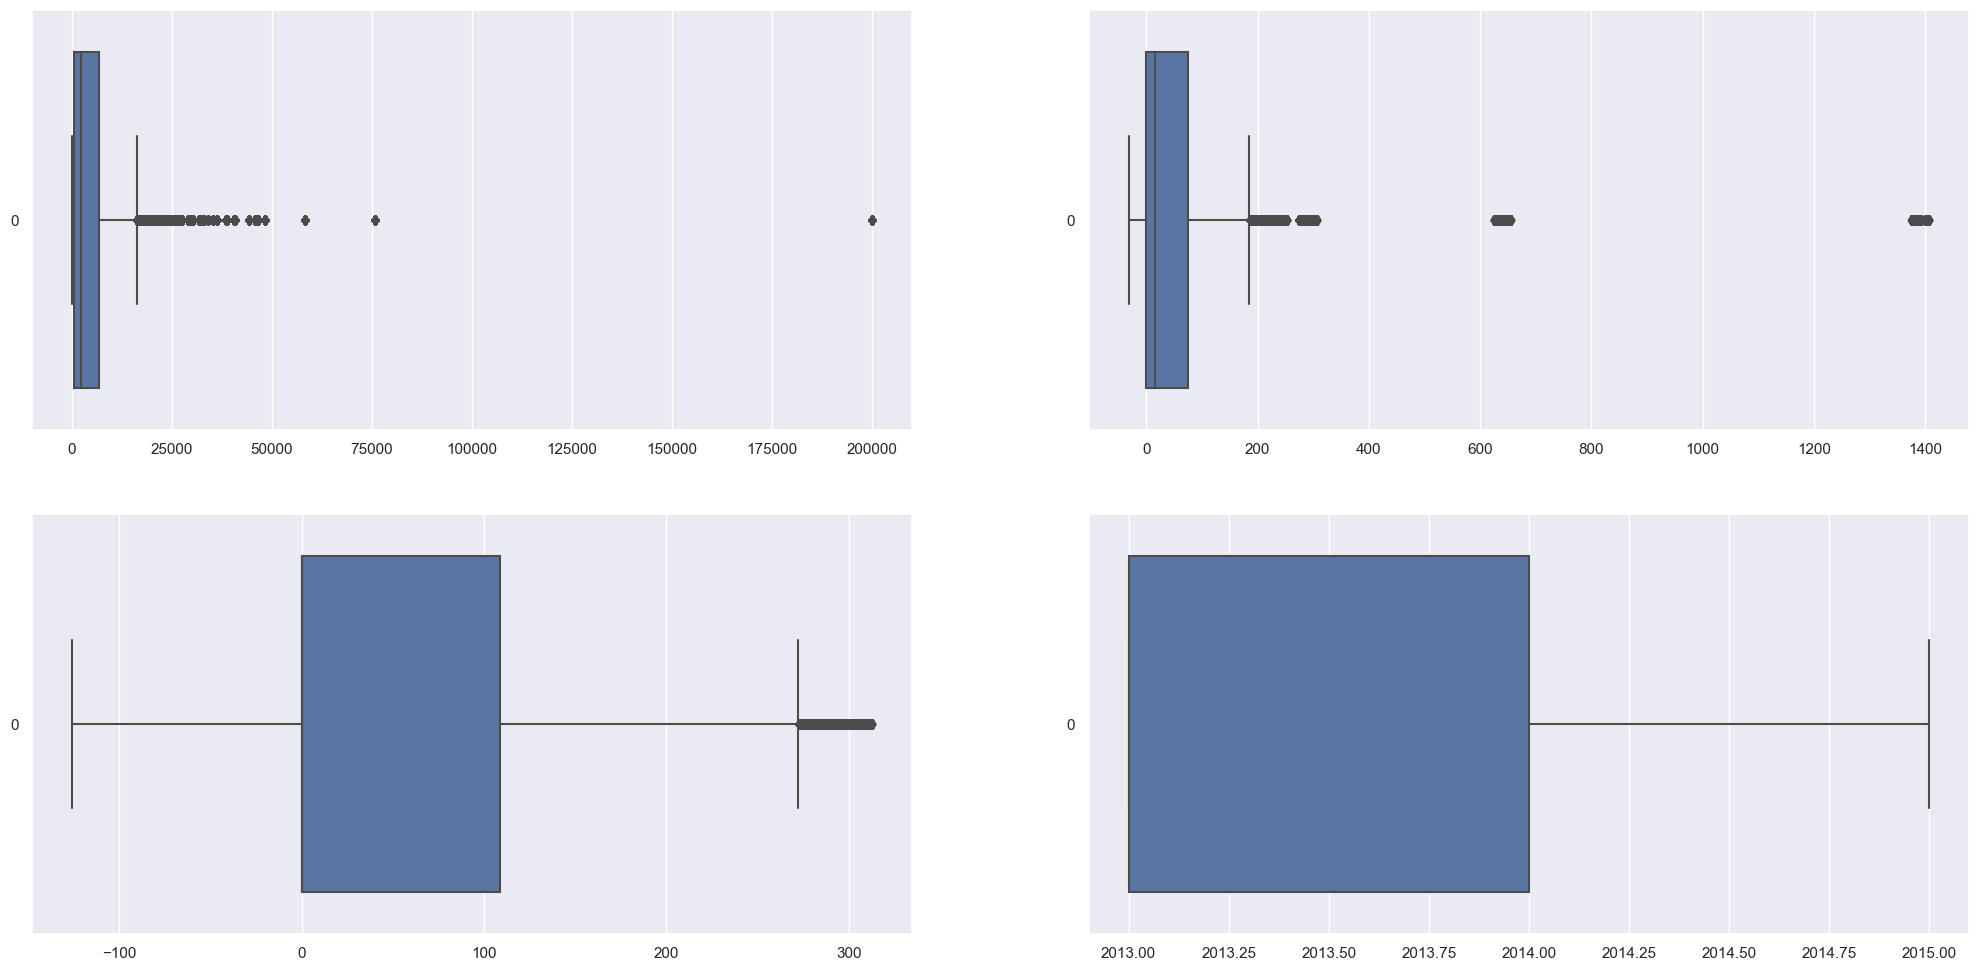

In [98]:
#Selecionando as variáveis que vamos aplicar o reecaling
#competition_distance
#year
#competition_time_month
#promo_time_week

#As outras variáveis ou foram usadas para chegar nessas, ou é o id da loja, ou nosso fenômeno ou são boleanas.

#Verificar se temos outliers
plt.subplot(2,2,1)
sns.boxplot(df5['competition_distance'],orient='h'); #Temos os outliers que colocamos no lugar dos NA
plt.subplot(2,2,2)
sns.boxplot(df5['competition_time_month'],orient='h');
plt.subplot(2,2,3)
sns.boxplot(df5['promo_time_week'],orient='h');
plt.subplot(2,2,4)
sns.boxplot(df5['year'],orient='h');

In [99]:
#Preparando os dados para o modelo, mantendo o seu comportamento, mas colocando em um range próximo de 1, que é facilmente aderido pelo modelo.

#'competition_distance' tem outliers, vamos usar o robust scale
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
with open('parameters\competition_distance_scaler.pkl','wb') as RS: #armazenando os dados
    pickle.dump(rs,RS)

#'competition_time_month' tem outliers, vamos usar o robust scale
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
with open('parameters\competition_time_month_scaler.pkl','wb') as RS1:
    pickle.dump(rs,RS1)

#promo_time_week não tem muitos outliers
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
with open('parameters\promo_time_week_scaler.pkl','wb') as MMS1:
    pickle.dump(mms,MMS1)

#year não é cíclico e não tem muitos outliers
df5['year'] = mms.fit_transform(df5[['year']].values)
with open('parameters\year_scaler.pkl','wb') as MMS2:
    pickle.dump(mms,MMS2)

## 5.3 Transformação

### 5.3.1 Encoding

In [101]:
#Variáveis categóricas
#state_holiday
#store_type
#assortment

In [102]:
#state_holiday - One Hot Encoding
#Cria uma coluna boleana para cada variável categórica
df5 = pd.get_dummies(df5,prefix=['state_holiday'],dtype='int64',columns=['state_holiday'])

#store_type - Label Encoding
#Trocando o nome das categorias por números
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
with open('parameters\store_type_scaler.pkl','wb') as LE:
    pickle.dump(le,LE)

#assortment - Ordinal Encoding
#Trocando o nome das categorias por números, mas com sentido de ordinalidade
assortment_dict = {'basic':1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [104]:
#Normalizando o fenômeno
df5['sales'] = np.log(df5['sales'])

### 5.3.3 Nature Transformation

In [105]:
#Variáveis com natureza cíclica
#month
#day
#week_of_year
#day_of_week

#Cria uma nova coluna que transforma o mês em um valor de seno e outro de cosseno, gerando uma relação cíclica entre as variáveis da coluna

In [106]:
#month - Ciclo de 12 meses
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

#day - Ciclo de 31
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

#week_of_year - Ciclo de 53
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

#day_of_week - Ciclo de 7
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# 6.0 Seleção de Variáveis

In [107]:
#Cópia de segurança 6
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [108]:
#Tirar as colunas que não importam no modelo
cols_drop = ['week_of_year','month','day','day_of_week','promo_since','competition_since','year-week']
df6 = df6.drop(cols_drop,axis=1)

In [109]:
#A previsão é para vendas daqui 6 semanas, então vamos utilizar as últimas 6 semanas como teste
#Do primeiro dia de venda até o início dessas 6 semanas vou usar para treino
#Com isso é possível simular e ver se o modelo vai acertar a previsão de 6 semanas com os dados de um preíodo anterior

In [110]:
#Verificando a data mínima e a máxima
df6[['store','date']].groupby('store').max().reset_index().head(5) #2015-07-31
df6[['store','date']].groupby('store').min().reset_index().head(5) #2013-01-02

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02


In [111]:
#Encontrando a data limite para definir os dados de treino e de teste
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [112]:
#Definindo o dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#Definindo o dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

min_xtrain = X_train['date'].min()
max_xtrain = X_train['date'].max()

min_xtest = X_test['date'].min()
max_xtest = X_test['date'].max()

print(f'Limites do xtrain: {min_xtrain} - {max_xtrain}')
print(f'Limites do xtrain: {min_xtest} - {max_xtest}')

Limites do xtrain: 2013-01-01 00:00:00 - 2015-06-18 00:00:00
Limites do xtrain: 2015-06-19 00:00:00 - 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [70]:
#Definindo os datasets para o Boruta
X_train_n = X_train.drop(['date','sales'],axis=1).values
Y_train_n = Y_train.values.ravel()

#Definindo o RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

#Definindo o Boruta
boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_n,Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	0
Rejected: 	10


### 6.2.1 Best Features from Boruta

In [71]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date','sales'],axis=1)
cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

#Colunas não selecianadas pelo boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns,cols_selected_boruta))

## 6.3 Manual Featura Selection

In [113]:
#Salvando as variáveis que o boruta julga importantes ou não
cols_not_selected_boruta_saved = [
     'is_promo',
     'month_sin',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'week_of_year_cos',
     'week_of_year_sin',
     'year']
cols_selected_boruta_saved = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'day_sin',
     'day_cos',
     'day_of_week_sin',
     'day_of_week_cos']

In [114]:
#A partir da avaliação dele vou usar as que eu acho importante
cols_not_selected_boruta_changed = [
     'is_promo',
     'month_sin',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'year']
cols_selected_boruta_changed = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'month_cos',
     'month_sin',
     'day_sin',
     'day_cos',
     'day_of_week_sin',
     'day_of_week_cos',
     'week_of_year_sin',
     'week_of_year_cos']

cols_selected_boruta_full = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 Machine Learning Modelling

In [115]:
#Mudar os parâmetros dos df apenas aqueles que selecionamos no boruta
x_train = X_train[cols_selected_boruta_changed]
x_test = X_test[cols_selected_boruta_changed]

x_training = X_train[cols_selected_boruta_full]

## 7.1 Avarage Model

In [73]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predctions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predctions']

#performance - Y_test é a coluna de sales que devemos encontrar e yhat_baseline é o que nosso método prediz
baseline_result = ml_error('Avarage Model',np.expm1(Y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800167,0.45515,1835.141019


## 7.2 Linear Regression Model

In [74]:
#model
lr = LinearRegression().fit(x_train,Y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance - Y_test é a coluna de sales que devemos encontrar e yhat_lr é o que nosso método prediz
lr_result = ml_error('Linear Regression',np.expm1(Y_test),np.expm1(yhat_lr))
lr_result

#Alto valor de RMSE, mostrando que o modelo linear com caracteriza bem esses dados

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.269017,0.292706,2671.589246


### 7.2.1 Linear Regression Model - Cross Validation

In [190]:
lr_result_cv = cross_validation(x_training,5,'Linear Regression',lr,verbose=False) 
lr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.69 +/- 295.46,0.3 +/- 0.02,2952.42 +/- 468.15


## 7.3 Linear Regression Regularized Model - Lasso

In [75]:
#model
lrr = Lasso(alpha=0.01).fit(x_train,Y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance - Y_test é a coluna de sales que devemos encontrar e yhat_lrr é o que nosso método prediz
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(Y_test),np.expm1(yhat_lrr))
lrr_result

#Alto valor de RMSE, mostrando que o modelo linear com caracteriza bem esses dados
#Menores valores de alpha podem gerar um menos erro RMSE
#Prova que o modelo é complexo, modelos lineares não irão aprendem esse comportamento

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.702083,0.289165,2744.462516


### 7.3.1 Lasso - Cross Validation

In [192]:
lrr_result_cv = cross_validation(x_training,5,'Lasso',lrr,verbose=False) 
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2116.64 +/- 341.57,0.29 +/- 0.01,3057.93 +/- 504.72


## 7.4 Random Forest Regression

In [76]:
#model
#n_estimators - quantas árvores vai criar
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=42).fit(x_train,Y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance - Y_test é a coluna de sales que devemos encontrar e yhat_rf é o que nosso método prediz
#Usamos o exp aqui para voltar os valores de sales normalizada anteriormente com o log, aplicando a operação inversa
rf_result = ml_error('Random Forest Regressor',np.expm1(Y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,667.434016,0.097598,996.03925


### 7.4.1 Random Forest - Cross Validation

In [201]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=42)
rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf,verbose=True) 
rf_result_cv

K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,843.22 +/- 223.13,0.12 +/- 0.02,1267.99 +/- 328.1


## 7.5 XGBoost Regressor

In [77]:
#model
#max_depth - profundidade máxima da árvore
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=200).fit( x_train, Y_train )

#prediction
yhat_xgb = model_xgb.predict( x_test )

#performance - Y_test é a coluna de sales que devemos encontrar e yhat_xgb é o que nosso método prediz
xgb_result = ml_error('XGBoost Regressor',np.expm1(Y_test),np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,756.970422,0.111236,1095.040393


### 7.5.1 XGBoost Regression - Cross Validation

In [213]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=200).fit( x_train, Y_train )
xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',model_xgb,verbose=True) 
xgb_result_cv

K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,1017.08 +/- 199.47,0.14 +/- 0.02,1460.88 +/- 298.91


## 7.6 Campare Model's Perfomance

### 7.6.1 Single Performance

In [78]:
modeling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,667.434016,0.097598,996.039250
0,XGBoost Regressor,756.970422,0.111236,1095.040393
0,Avarage Model,1354.800167,0.455150,1835.141019
0,Linear Regression,1867.269017,0.292706,2671.589246
0,Linear Regression - Lasso,1891.702083,0.289165,2744.462516


In [101]:
#modeling_result_saved = pd.DataFrame({'Model Name':['Random Forest Regressor','XGBoost Regressor','Avarage Model','Linear Regression','Linear Regression - Lasso'],
#                                    'MAE':[667.434016,865.346753,1354.800167,1867.269017,1891.702083],
#                                    'MAPE':[0.097598,0.127414,0.455150,0.292706,0.289165],
#                                    'RMSE':[996.039250,1259.711727,1835.141019,2671.589246,2744.462516]})

### 7.6.2 Real Performance - Cross Validation

In [207]:
modeling_result = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
modeling_result.sort_values('RSME CV')

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,843.22 +/- 223.13,0.12 +/- 0.02,1267.99 +/- 328.1
0,XGBoost Regressor,1122.76 +/- 212.97,0.15 +/- 0.02,1622.46 +/- 317.51
0,Linear Regression,2081.69 +/- 295.46,0.3 +/- 0.02,2952.42 +/- 468.15
0,Lasso,2116.64 +/- 341.57,0.29 +/- 0.01,3057.93 +/- 504.72


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [83]:
#Definindo parâmetros aleatórios para o Random Search
param = {
    'n_estimators':[1500,1700,2500,3000,3500],
    'eta':[0.01,0.03],
    'max_depth':[3,5,9],
    'subsample':[0.1,0.5,0.7],
    'colsample_bytree':[0.3,0.7,0.9],
    'min_child_weight':[3,8,15]}

max_eval = 5

In [85]:
#Aplicando o Random Search
final_result = pd.DataFrame()

for i in range(max_eval):
    #choose valores for parameters randomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items()}
    print(hp)
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'],
                                  eta=hp['eta'],
                                  max_depth=hp['max_depth'],
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'])

    #performance
    result = cross_validation(x_training,5,'XGBoost Regressor',model_xgb,verbose=True) 
    final_result = pd.concat([final_result,result])

final_result

{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 2500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 8}
K = 5
K = 4
K = 3
K = 2
K = 1
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
K = 5
K = 4
K = 3
K = 2
K = 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,857.21 +/- 136.12,0.12 +/- 0.01,1235.62 +/- 198.09
0,XGBoost Regressor,1352.16 +/- 136.49,0.19 +/- 0.01,1954.05 +/- 171.16
0,XGBoost Regressor,1164.57 +/- 128.11,0.16 +/- 0.01,1685.25 +/- 166.17
0,XGBoost Regressor,1356.8 +/- 140.39,0.19 +/- 0.01,1963.81 +/- 192.03
0,XGBoost Regressor,847.42 +/- 123.96,0.12 +/- 0.01,1228.0 +/- 194.18


## 8.2 Final Model

In [116]:
#A partir do Random Search esses foram os parâmetros escolhidos
param_tuned = {
    'n_estimators':1700,
    'eta':0.03,
    'max_depth':9,
    'subsample':0.7,
    'colsample_bytree':0.3,
    'min_child_weight':8}

In [117]:

model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=param_tuned['n_estimators'],
                                  eta=param_tuned['eta'],
                                  max_depth=param_tuned['max_depth'],
                                  subsample=param_tuned['subsample'],
                                  colsample_bytree=param_tuned['colsample_bytree'],
                                  min_child_weight=param_tuned['min_child_weight']).fit(x_train,Y_train)

#predction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )


#performance
xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(Y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,687.286713,0.101122,990.867971


In [118]:
print(f'Valor mínimo de teste')
print(np.expm1(Y_test).min())
print(f'\nValor máximo de teste')
print(np.expm1(Y_test).max())
print(f'\nRange de teste')
print(np.expm1(Y_test).max() - np.expm1(Y_test).min())
print(f'\nValor médio de teste')
print(np.expm1(Y_test).mean())
print(f'\nErro MAE')
print(xgb_result_tuned['MAE'][0])
print(f'\nErro MAE/Valor médio do teste = MAPE')
print(xgb_result_tuned['MAE'][0]/np.expm1(Y_test).mean())
print(f'\nErro RMSE/Valor médio do teste = RMSPE')
print(xgb_result_tuned['RMSE'][0]/np.expm1(Y_test).mean())
print(f'Essa é a porcentagem do erro considerando os outliers como relevantes.')
print(f'\nErro MPE')
print(mean_percentage_error(np.expm1(Y_test),np.expm1(yhat_xgb_tuned)))
print(f'Vemos que o modelo está em sua maioria superestimando os dados de teste')

Valor mínimo de teste
568.0

Valor máximo de teste
41550.0

Range de teste
40982.0

Valor médio de teste
6994.162576094309

Erro MAE
687.286713396965

Erro MAE/Valor médio do teste = MAPE
0.09826576175768002

Erro RMSE/Valor médio do teste = RMSPE
0.14167070902931825
Essa é a porcentagem do erro considerando os outliers como relevantes.

Erro MPE
-0.005213805728952323
Vemos que o modelo está em sua maioria superestimando os dados de teste


# 9.0 Tradução e interpretação do erro

In [119]:
df9 = X_test[cols_selected_boruta_full]

#rescale - dados estão logarítmos para serem usados no modelo
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Bussiness Performance

In [120]:
#Somar as predições - Saber o quanto de dinheiro vai entrar por causa do modelo
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE E MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge dos erros
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92 = pd.merge(df91,df9_aux3,how='inner',on='store')

#Toda linhas tem sua predição, seu erro MAE, e esse erro em valor corresponde a porcentagem do MAPE.

#O pior cenário é a predição menos o erro MAE
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
#O melhor cenário é a predição mais o erro MAE
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

#Com esses dados o tomador de decisão pode ver qual a predição dos melhores e piores cenários e seus erros, podendo tomar a decisão considerando isso.
#Os melhores e piores cenários foram gerados através do MAE
#Na regressão medimos os valores próximos do real, por isso usamos o erro, que mede o quão longe estamos do valor real

In [121]:
#Lojas com maior valor de MAPE, com erros percentuais muito grandes
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107838.242188,104487.621235,111188.863140,3350.620952,0.582583
908,909,233397.484375,225597.388905,241197.579845,7800.095470,0.526004
875,876,196217.312500,192237.595777,200197.029223,3979.716723,0.310853
674,675,159726.031250,158857.975474,160594.087026,868.055776,0.276710
169,170,187639.765625,186650.283183,188629.248067,989.482442,0.250300


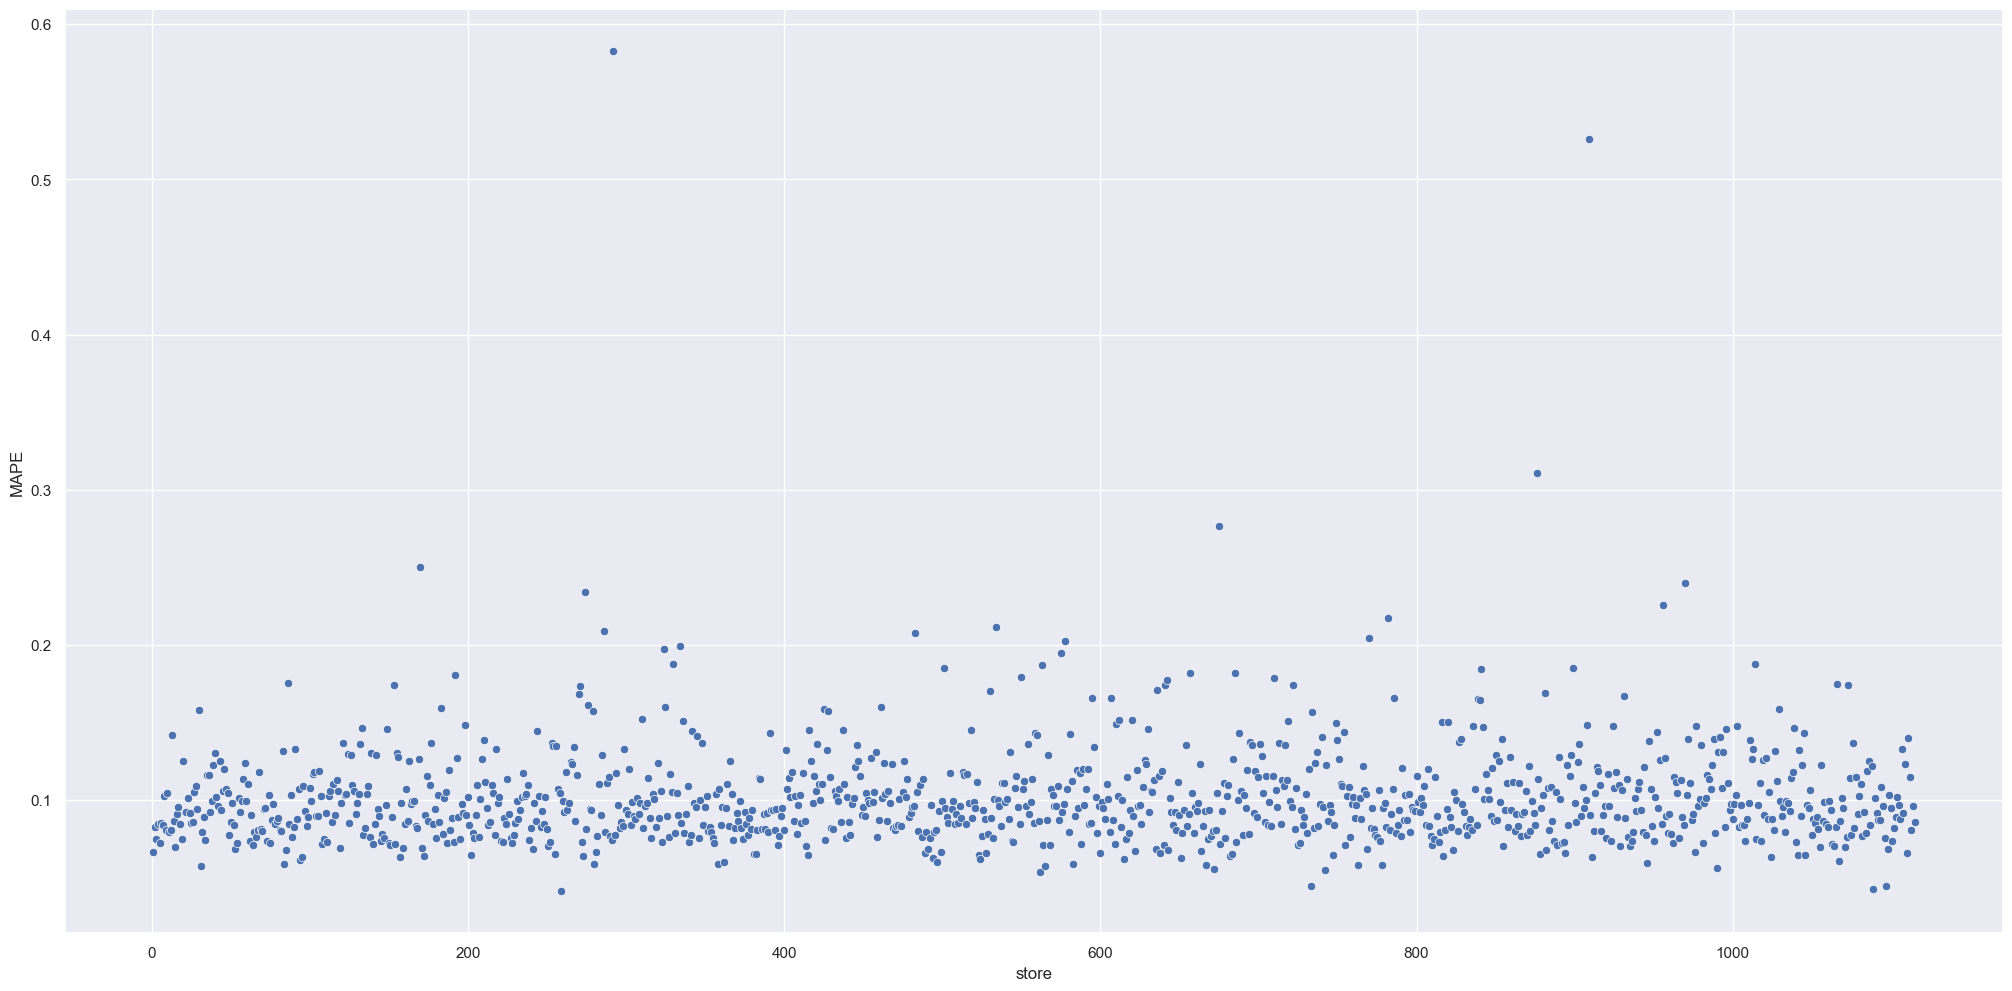

In [122]:
#Gráfico com todos os MAPES, mostra que tem lojas mais desafiadoras que as outras, mais que a maioria tem o MAPE baixo
sns.scatterplot(x='store',y='MAPE',data=df92);

## 9.2 Total Performance

In [123]:
#Somando as colunas - Total de predições, melhor e pior cenário
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})

#Colocando em reais
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93.head()

,Scenario,Values
0,predictions,"R$284,615,072.00"
1,worst_scenario,"R$283,844,721.87"
2,best_scenario,"R$285,385,428.41"


## 9.3 Machine Learning Performance

In [124]:
#Criando as variáveis de erro
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

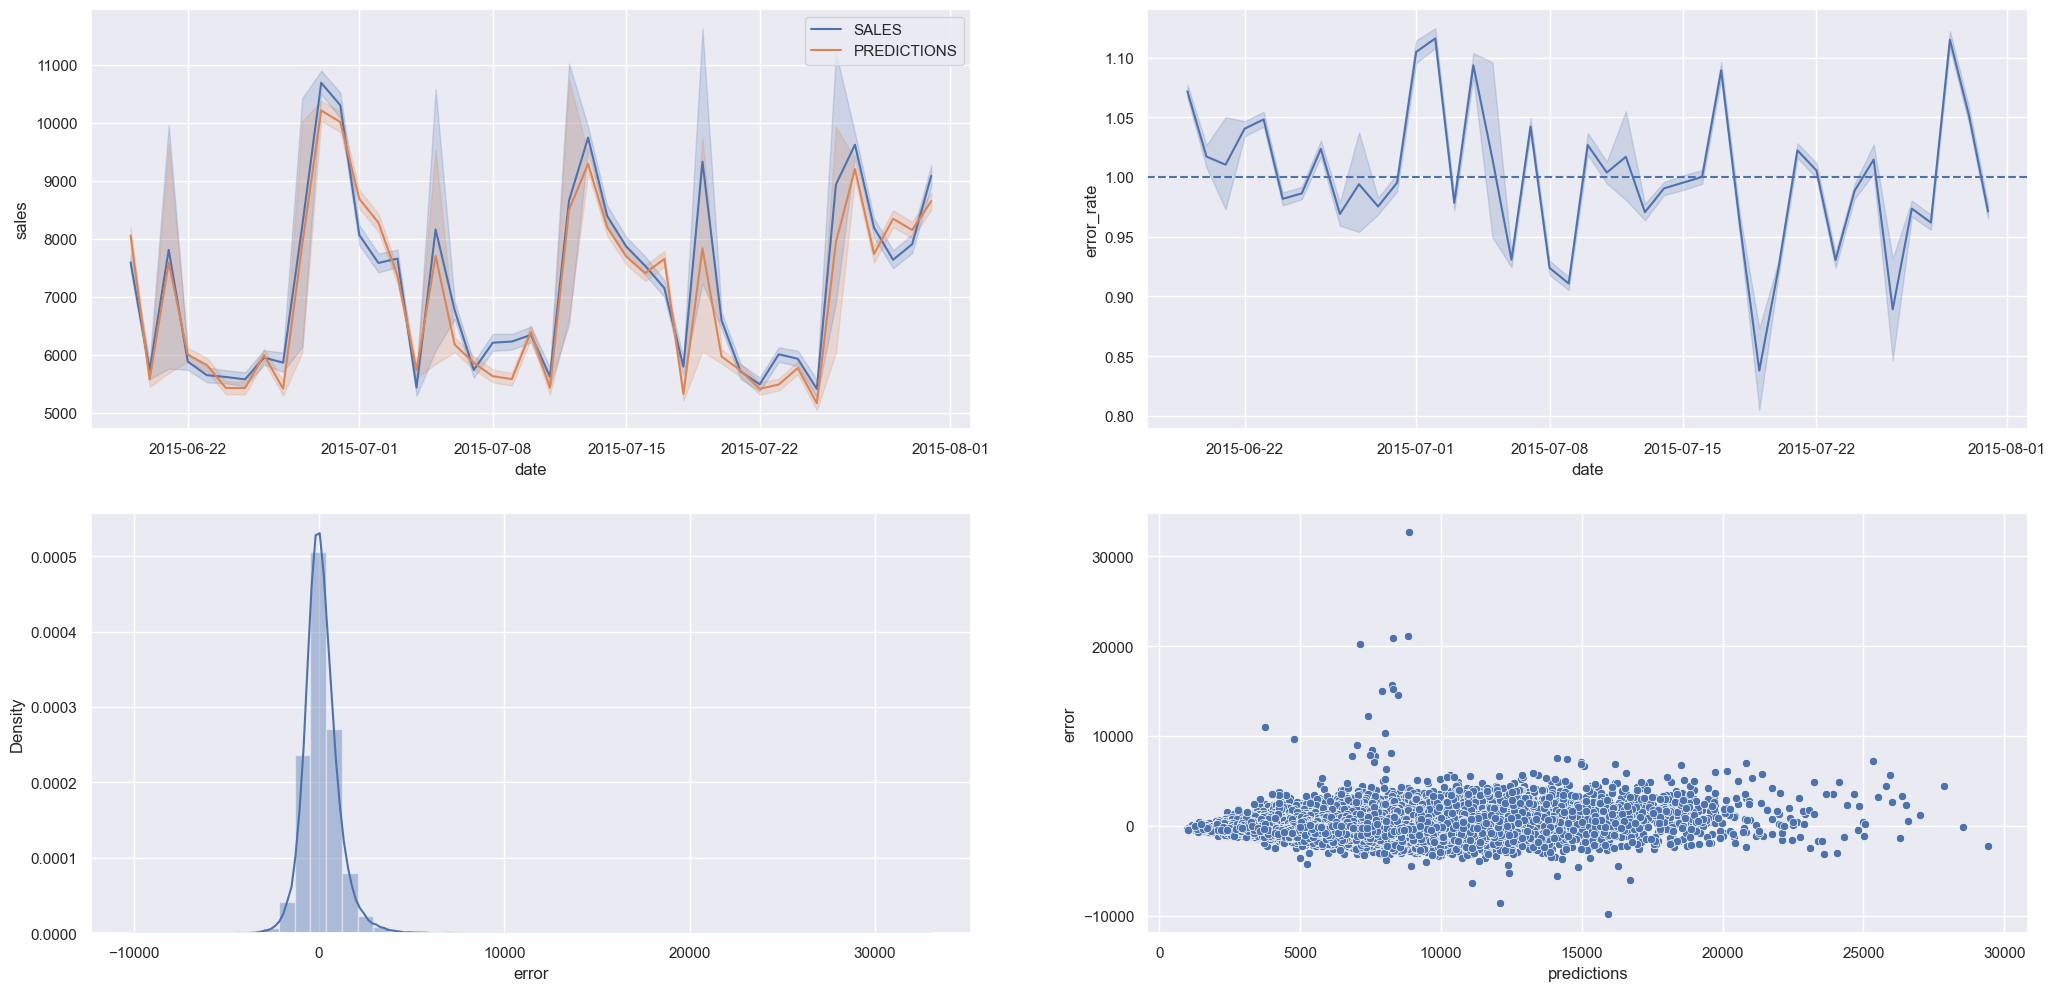

In [125]:
#Compara os valores de vendas com os valores preditos, para vermos o comportamento
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS');

#Comportamento da porcentagem das previsões em relação as vendas
#Consegue ver como está a superestimação e a subestimação
plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9);
plt.axhline(1,linestyle='--') #Linha tracejada no 1

#Comporamento do erro é uma distribuição normal
#Usado em análise do resíduo, usada para melhorar o modelo apontando os pontos fracos
plt.subplot(2,2,3)
sns.distplot(df9['error']);

#Predições com relação ao erro
#Podemos ver como o erro varia com o valor das predições e tentar perceber onde esse erro é mais crítico
#Erro preciso ficar dentro de um tubo, como está
plt.subplot(2,2,4)
sns.scatterplot(x='predictions',y='error',data=df9);

# 10.0 Deploy Model to Production

## 10.1 Rossmann Class

In [126]:
#Código que foi passado para o arquivo Rossman.py

import pickle
import inflection
import pandas as pd
import numpy as np
import math
import time
from datetime import datetime,timedelta

class Rossmann(object):
    def __init__(self):
        self.home_path = 'C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/ds_em_producao/meus_arquivos/'
        with open(self.home_path + 'parameters/competition_distance_scaler.pkl','rb') as RS:
            self.competition_distance_scaler   = pickle.load(RS)
        with open(self.home_path + 'parameters/competition_time_month_scaler.pkl','rb') as RS1:
            self.competition_time_month_scaler = pickle.load(RS1)
        with open(self.home_path + 'parameters/promo_time_week_scaler.pkl','rb') as MMS1:
            self.promo_time_week_scaler        = pickle.load(MMS1)
        with open(self.home_path + 'parameters/year_scaler.pkl','rb') as MMS2:
            self.year_scaler                   = pickle.load(MMS2)
        with open(self.home_path + 'parameters/store_type_scaler.pkl','rb') as LE:
             self.store_type_scaler            = pickle.load(LE)
    
    def data_cleaning(self,df1):
        """Recebe um df1 e limpa ele"""
        ## 1.1 Rename Columns

        #Colocando como snake case
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']

        snake_case = lambda x: inflection.underscore(x)
        cols_new = list(map(snake_case,cols_old))

        ##Rename
        df1.columns = cols_new
        df1.columns

        ## 1.3 Data Types

        #Muda o tipo do date de object para data
        df1['date'] = pd.to_datetime(df1['date'])


        ## 1.5 Fillout NA

        #competition_distance              2642
        #Vamos completar essa coluna com um valor muito mais alto que o maior valor da caluna, pois para ela ser NA
        #Essa loja não tem um competidor próximo, então colocamos um alto valor para representar isso
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x : 200000 if math.isnan(x) else x)


        #competition_open_since_month    323348
        #Nesse caso, vamos utilizar a data que temos como parâmetro para essa data
        #Derivamos o mes de date para o início da data de competição
        df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)


        #competition_open_since_year     323348
        df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)


        #promo2_since_week               508031
        df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


        #promo2_since_year               508031
        df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval                  508031
        month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

        df1['promo_interval'].fillna(0,inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0,axis=1)

        ## 1.6 Change Types

        #Depois de alterar os dados das colunas é bom conferir os tipos de ajustá-los
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engeneering(self,df2):
    
        #Variáveis para devivar de date
        #year, month, day, week of year, year week
        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day
        df2['week_of_year'] = df2['date'].dt.strftime("%U")
        df2['week_of_year'].astype(int)
        df2['year-week'] = df2['date'].dt.strftime('%Y-%W')


        #Variáveis de competição
        #competition since, promo since
        #Juntar o ano da competição com o mês para mostrar o tempo da competição ativa por mês
        df2['competition_since'] = df2.apply(lambda x: datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        #Tempo que minha competição está ativa em semanas
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.strptime(x + '-1' , '%Y-%W-%w') - timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype('int64')


        #Variáveis que estão com letras e quero trocar por nomes
        #assostment,state holiday
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0 Filtragem de variáveis

        ## 3.1 Filtragem das linhas

        #open não tem aprendizado, pois quando está fechado não influencia na quantidade de vendas, precisa ser diferente de 0
        #sales precisa ser maior que zero, para não considerar os dias fechados

        df2 = df2[(df2['open'] != 0)]

        ## 3.2 Seleção das Colunas

        #custumers não tem como usar no momento da predição, pois não tem como saber quantos clientes vão ter na loja para influenciar na venda

        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop,axis=1)

        return df2

    def data_preparation(self,df5):

        ## 5.2 Rescaling
        #Como já temos o modelo pronto e carregado, utilizamos o transform ao invés do fit_transform
        #'competition_distance' tem outliers, vamos usar o robust scale
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        #'competition_time_month' tem outliers, vamos usar o robust scale
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        #promo_time_week não tem muitos outliers
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        #year não é cíclico e não tem muitos outliers
        df5['year'] = self.year_scaler.transform(df5[['year']].values)
        
        ### 5.3.1 Encoding

        #state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'],dtype='int64',columns=['state_holiday'])

        #store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform(df5['store_type'])


        #assortment - Ordinal Encoding
        assortment_dict = {'basic':1,'extra':2,'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation

        #month - Ciclo de 12 meses
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        #day - Ciclo de 31
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        #week_of_year - Ciclo de 53
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

        #day_of_week - Ciclo de 7
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
             'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week',
             'month_cos','month_sin','day_sin','day_cos','day_of_week_sin','day_of_week_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self,model,original_data,test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')

## 10.2 - API Handler Class

In [381]:
#Código que foi passado para o arquivo Handler.py

import pandas as pd
from flask import Flask,request,Response
from rossmann.Rossmann import Rossmann
import pickle

#Carregando model
model = pickle.load(open('C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/ds_em_producao/meus_arquivos/model/model_xgb_tuned.pkl','rb'))


#Inicializando o API
app = Flask(__name__) #instanciando o Flask

#Criar o endpoint
@app.route('/rossmann/predict',methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json: #Tem os dados
        if isinstance(test_json,dict): #Veio único, uma linha - Unique Example
            test_raw = pd.DataFrame(test_json,index=[0])
            
        else: #Multiples Examples
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
        
    else:
        return Response('{}',status=200,mimetype='application/json')
    
    #Instanciando a Classe Rossmann
    pipeline = Rossmann()
    
    #Limpeza de dados
    df1 = pipeline.data_cleaning(test_raw)
    
    #Crianção de Features
    df2 = pipeline.feature_engeneering(df1)
    
    #Prepatação dos dados
    df3 = pipeline.data_preparation(df2)
    
    #Predição dos dados
    df_response = pipeline.get_prediction(model,test_raw,df3)
    
    return df_response
    


if __name__ == '__main__':
    app.run('0.0.0.0') #Indica o local hold

ModuleNotFoundError: No module named 'rossmann'

## 10.3 - API Tester

In [127]:
#Código para o teste da API

import requests

#Loadting Test Dataset
df10 = pd.read_csv('C:/Users/ian-g/OneDrive/Documentos/Comunidade DS/ds_em_producao/meus_arquivos/dataset/test.csv')

#merge test dataset + store
df_test = pd.merge(df10,df_store_raw,how='left',on='Store')

#Choose store for prediction
df_test = df_test[df_test['Store'].isin([20,21,22,23])] #Selecionando as lojas

#Limpeza dos dados com a loja fechada
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

#Converter dataframe para jason
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'https://rossmann-model-api-xmlj.onrender.com/rossmann/predict' #Porta 5000 é a padrão do Flask
#Quero entrar no meu local host, pela porta 5000, com o endpoint /rossmann/predict
header = {'Content-type': 'application/json'}
data = data

#Post - Envia dados
r = requests.post(url,data=data,headers=header)
print(f'Status Code {r.status_code}')

#Transformando o arquivo json em dataframe
d1 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

d2 = d1[['store','prediction']].groupby('store').sum().reset_index()


for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks.'.format(d2.iloc[i,0],d2.iloc[i,1]))

Status Code 200
Store Number 20 will sell R$299,385.08 in the next 6 weeks.
Store Number 21 will sell R$224,326.68 in the next 6 weeks.
Store Number 22 will sell R$175,114.57 in the next 6 weeks.
Store Number 23 will sell R$221,026.06 in the next 6 weeks.
